# Top

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

sns.set_theme()
sns.set_palette("husl")

In [66]:
file_path = '/kaggle/input/player-football/cleaned_player_data.csv'
df = pd.read_csv(file_path)
original_df = df.copy()
df.head()

playerId                   name               contractUntil  teamId  \
0    561613            Joan García  2031-06-29 22:00:00.000000     131   
1     74857  Marc-André ter Stegen  2028-06-29 22:00:00.000000     131   
2     44058      Wojciech Szczesny  2027-06-29 22:00:00.000000     131   
3    962110            Pau Cubarsí  2029-06-29 22:00:00.000000     131   
4    466794            Eric García  2031-06-29 22:00:00.000000     131   

             teamName date_of_birth   age  height preferredFoot     position  \
0  FC Barcelona ~ 131    2001-05-04  24.0    1.94         right   Goalkeeper   
1  FC Barcelona ~ 131    1992-04-30  33.0    1.87         right   Goalkeeper   
2  FC Barcelona ~ 131    1990-04-18  35.0    1.95         right   Goalkeeper   
3  FC Barcelona ~ 131    2007-01-22  18.0    1.84         right  Centre-Back   
4  FC Barcelona ~ 131    2001-01-09  24.0    1.82         right  Centre-Back   

   ... savesParried totalOwnHalfPasses  totalOppositionHalfPasses  \
0  ...         21.0              625.0                      434.0   
1  ...          1.0              184.0                       27.0   
2  ...          6.0              345.0                       46.0   
3  ...          0.0             1498.0                     1095.0   
4  ...          0.0              573.0                      721.0   

   totwAppearances  expectedGoals  goalKicks  ballRecovery       id     type  \
0              7.0         0.0741      216.0         392.0  1519597  overall   
1              0.0         0.0000       27.0          59.0  1513902  overall   
2              0.0         0.0000       54.0         122.0  1794211  overall   
3              2.0         0.8260       10.0         102.0  1513933  overall   
4              0.0         2.3181        1.0          54.0  1513895  overall   

  appearances  
0          38  
1           8  
2          15  
3          35  
4          29  

[5 rows x 132 columns]

In [67]:
df['firstSidePositionId'] = df['firstSidePositionId'].fillna(-1)
df['secondSidePositionId'] = df['secondSidePositionId'].fillna(-1)
df.loc[df['rating'] == 0, 'rating'] = df.loc[df['rating'] != 0, 'rating'].mean()

In [68]:
def cvt2Year(s):
    return s[:4]

df['contractUntil'] = pd.to_numeric(df['contractUntil'].apply(cvt2Year))

In [69]:
df = df.drop(["MarketValueCurrency", "type"], axis=1)

In [70]:
df.select_dtypes('number').shape

(5466, 122)

In [71]:
df.columns.to_list()

['playerId',
 'name',
 'contractUntil',
 'teamId',
 'teamName',
 'date_of_birth',
 'age',
 'height',
 'preferredFoot',
 'position',
 'firstSidePosition',
 'secondSidePosition',
 'nationalityId',
 'MarketValueCurrent',
 'preferredFootId',
 'positionId',
 'firstSidePositionId',
 'secondSidePositionId',
 'MarketValuePrevious',
 'player_name',
 'rating',
 'totalRating',
 'countRating',
 'goals',
 'bigChancesCreated',
 'bigChancesMissed',
 'assists',
 'expectedAssists',
 'goalsAssistsSum',
 'accuratePasses',
 'inaccuratePasses',
 'totalPasses',
 'accuratePassesPercentage',
 'accurateOwnHalfPasses',
 'accurateOppositionHalfPasses',
 'accurateFinalThirdPasses',
 'keyPasses',
 'successfulDribbles',
 'successfulDribblesPercentage',
 'tackles',
 'interceptions',
 'yellowCards',
 'directRedCards',
 'redCards',
 'accurateCrosses',
 'accurateCrossesPercentage',
 'totalShots',
 'shotsOnTarget',
 'shotsOffTarget',
 'groundDuelsWon',
 'groundDuelsWonPercentage',
 'aerialDuelsWon',
 'aerialDuelsWonPerc

In [72]:
df.select_dtypes(include="object")

name                         teamName date_of_birth  \
0               Joan García               FC Barcelona ~ 131    2001-05-04   
1     Marc-André ter Stegen               FC Barcelona ~ 131    1992-04-30   
2         Wojciech Szczesny               FC Barcelona ~ 131    1990-04-18   
3               Pau Cubarsí               FC Barcelona ~ 131    2007-01-22   
4               Eric García               FC Barcelona ~ 131    2001-01-09   
...                     ...                              ...           ...   
5461                 Hudson  Esporte Clube Juventude ~ 10492    2001-01-14   
5462                Mandaca  Esporte Clube Juventude ~ 10492    2001-10-02   
5463                Rafinha  Esporte Clube Juventude ~ 10492    2002-11-18   
5464          Gabriel Veron  Esporte Clube Juventude ~ 10492    2002-09-03   
5465        Gabriel Taliari  Esporte Clube Juventude ~ 10492    1997-04-13   

     preferredFoot            position   firstSidePosition  \
0            right          Goalkeeper                 NaN   
1            right          Goalkeeper                 NaN   
2            right          Goalkeeper                 NaN   
3            right         Centre-Back                 NaN   
4            right         Centre-Back          Right-Back   
...            ...                 ...                 ...   
5461         right  Defensive Midfield          Right-Back   
5462         right    Central Midfield  Defensive Midfield   
5463         right  Attacking Midfield    Central Midfield   
5464         right        Right Winger         Left Winger   
5465         right      Centre-Forward                 NaN   

      secondSidePosition            player_name  
0                    NaN            Joan García  
1                    NaN  Marc-André ter Stegen  
2                    NaN      Wojciech Szczesny  
3                    NaN            Pau Cubarsí  
4     Defensive Midfield            Eric García  
...                  ...                    ...  
5461                 NaN                 Hudson  
5462       Left Midfield                Mandaca  
5463                 NaN                Rafinha  
5464      Second Striker          Gabriel Veron  
5465                 NaN        Gabriel Taliari  

[5466 rows x 8 columns]

# Feature selection

## df include "MarketValuePrevious"

In [73]:
# X = df.drop(['MarketValueCurrent', 'MarketValuePrevious'], axis=1)
drop_cols = ['player_name', 'preferredFoot',
                'position', 'firstSidePosition', 'secondSidePosition', 'teamName', 'name',
                'date_of_birth', 'MarketValueCurrent', 'playerId', 'id']
X = df.drop(drop_cols, axis=1).select_dtypes("number")
y = df['MarketValueCurrent']

cols = X.columns

X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf = RandomForestRegressor(
    n_estimators=136,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

# grid_random = {
#     'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf_random = RandomizedSearchCV(
#     estimator = rf,
#     param_distributions = grid_random,
#     n_iter = 20, # Number of parameter settings to sample
#     cv = 3,
#     verbose = 2,
#     random_state = 42,
#     n_jobs = -1
# )

rf.fit(X_train, y_train)
# rf_random.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# y_pred = rf_random.predict(X_test)
# best_params = rf_random.best_params_
# {'n_estimators': 136, 'min_samples_split': 10, 'min_samples_leaf': 1}

In [74]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
result_df.head()

Actual     Predicted
5361  4000000.0  4.390392e+06
1086  5000000.0  4.481784e+06
5048  2500000.0  2.803029e+06
3618   400000.0  4.792306e+05
2921  1500000.0  1.013633e+06

<Axes: ylabel='Actual'>

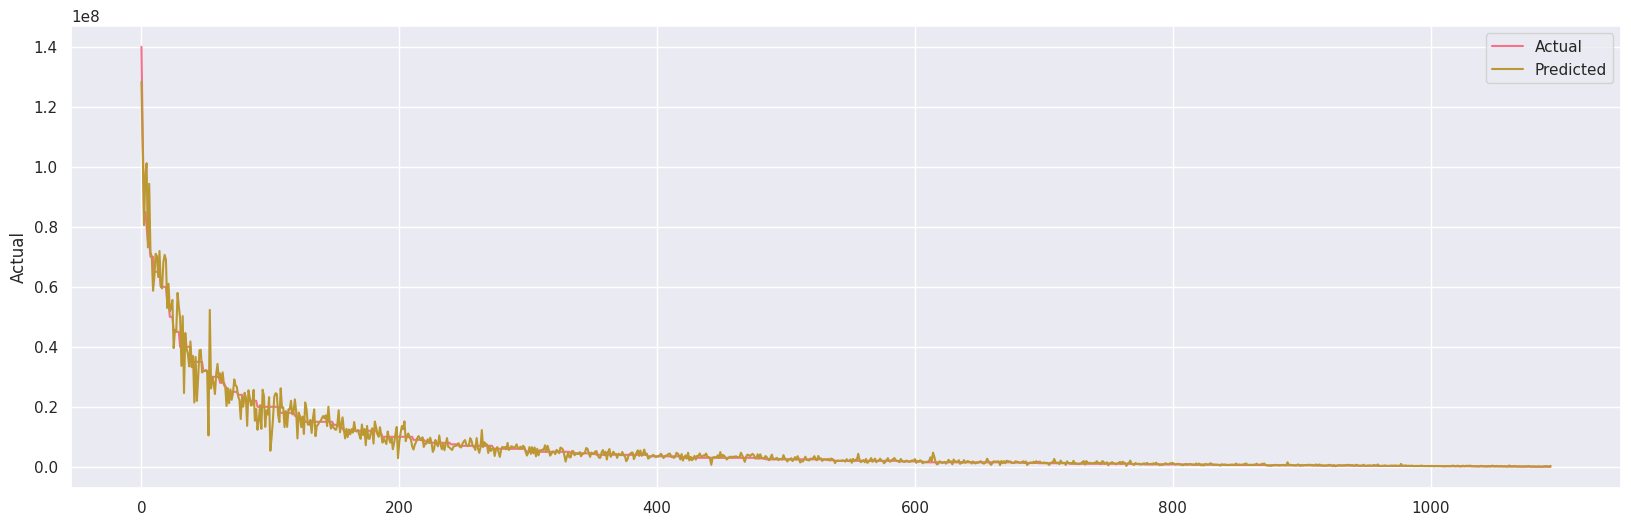

In [75]:
# y_test[y_test == 0] = 0.001
#  (y_test - y_pred) / y_test
plt.figure(figsize=(20, 6))
plot_result_df = result_df.sort_values(by='Actual', ascending=False)
sns.lineplot(plot_result_df, x=range(len(plot_result_df)), y='Actual', label='Actual')
sns.lineplot(plot_result_df, x=range(len(plot_result_df)), y='Predicted', label='Predicted')

In [76]:
loss = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {loss**0.5}")

Root Mean Squared Error: 2357255.9656582307


/tmp/ipykernel_55/3584765293.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


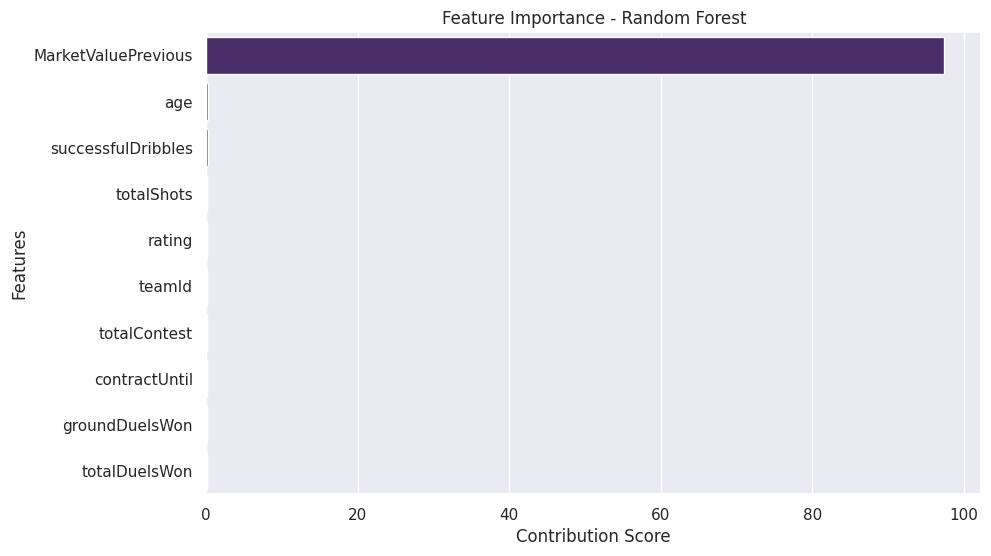

In [77]:
importances = rf.feature_importances_ * 100 # percentage
feature_names = X.columns

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sort highest -> lowest
feature_df = feature_df.sort_values(by='Importance', ascending=False)[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')

plt.title('Feature Importance - Random Forest')
plt.xlabel('Contribution Score')
plt.ylabel('Features')
plt.show()

It looks obvious, the player value really depends on their value in the previous transfer.

## df without "MarketValuePrevious"

### Random Forest

In [78]:
drop_cols = ['player_name', 'preferredFoot',
                'position', 'firstSidePosition', 'secondSidePosition', 'teamName', 'name',
                'date_of_birth', 'MarketValueCurrent', 'MarketValuePrevious', 'playerId', 'id']
X_2 = df.drop(drop_cols, axis=1)
y_2 = df['MarketValueCurrent']

cols = X_2.columns

X_2 = pd.DataFrame(X_2, columns=cols)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

params_2 = {'n_estimators': 188, 'min_samples_split': 5, 'min_samples_leaf': 4}
rf_2 = RandomForestRegressor(**params_2, random_state=42)

# grid_random = {
#     'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4, 6, 8]
# }

# rf_random_2 = RandomizedSearchCV(
#     estimator = rf_2,
#     param_distributions = grid_random,
#     n_iter = 20,
#     cv = 3,
#     verbose = 2,
#     random_state = 42,
#     n_jobs = -1
# )

rf_2.fit(X_train_2, y_train_2)
# rf_random_2.fit(X_train_2, y_train_2)
y_pred_2 = rf_2.predict(X_test_2)
# y_pred_2 = rf_random_2.predict(X_test_2)
# params_2 = rf_random_2.best_params_
# {'n_estimators': 188, 'min_samples_split': 5, 'min_samples_leaf': 4}

In [79]:
result_df_2 = pd.DataFrame({
    'Actual': y_test_2,
    'Predicted': y_pred_2
})
result_df_2.head()

Actual     Predicted
5361  4000000.0  4.498404e+06
1086  5000000.0  1.085165e+07
5048  2500000.0  1.163441e+06
3618   400000.0  1.557598e+06
2921  1500000.0  7.061392e+05

<Axes: ylabel='Actual'>

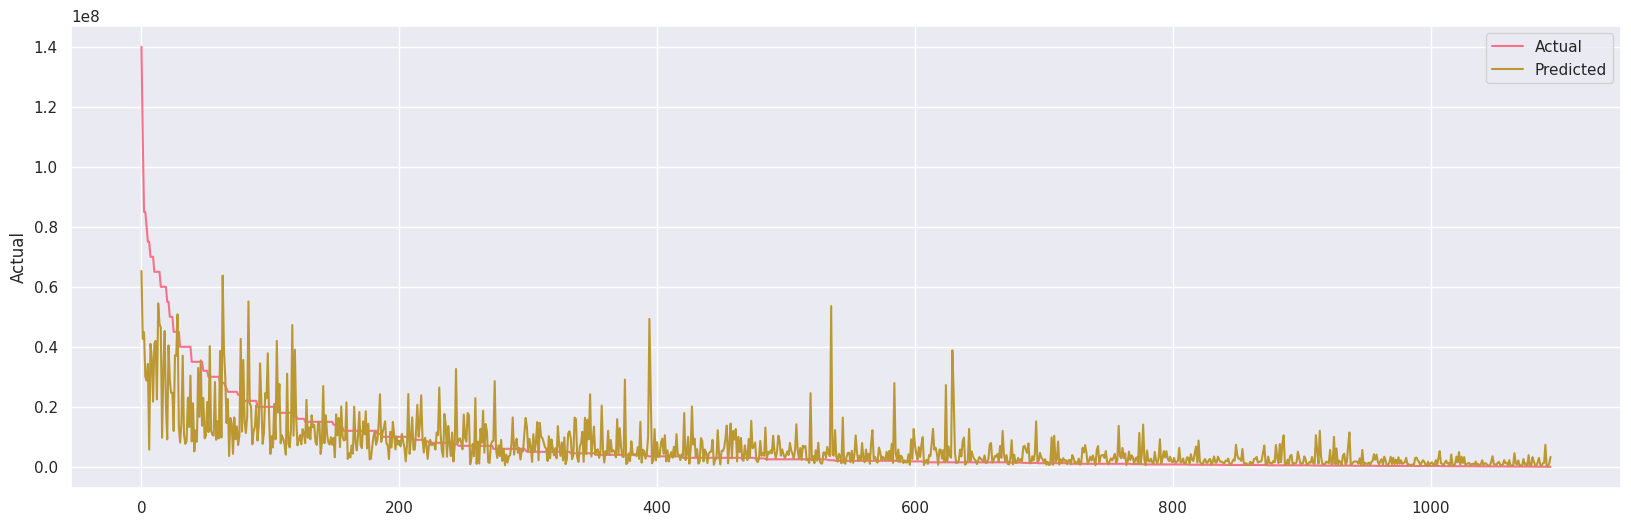

In [80]:
plot_result_df_2 = result_df_2.sort_values(by='Actual', ascending=False)
plt.figure(figsize=(20, 6))
sns.lineplot(plot_result_df_2, x=range(len(plot_result_df_2)), y='Actual', label='Actual')
sns.lineplot(plot_result_df_2, x=range(len(plot_result_df_2)), y='Predicted', label='Predicted')

In [81]:
loss = mean_squared_error(y_test_2, y_pred_2)
print(f"Root mean Squared Error: {loss}")

Root mean Squared Error: 86476143414172.03


/tmp/ipykernel_55/3514874158.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


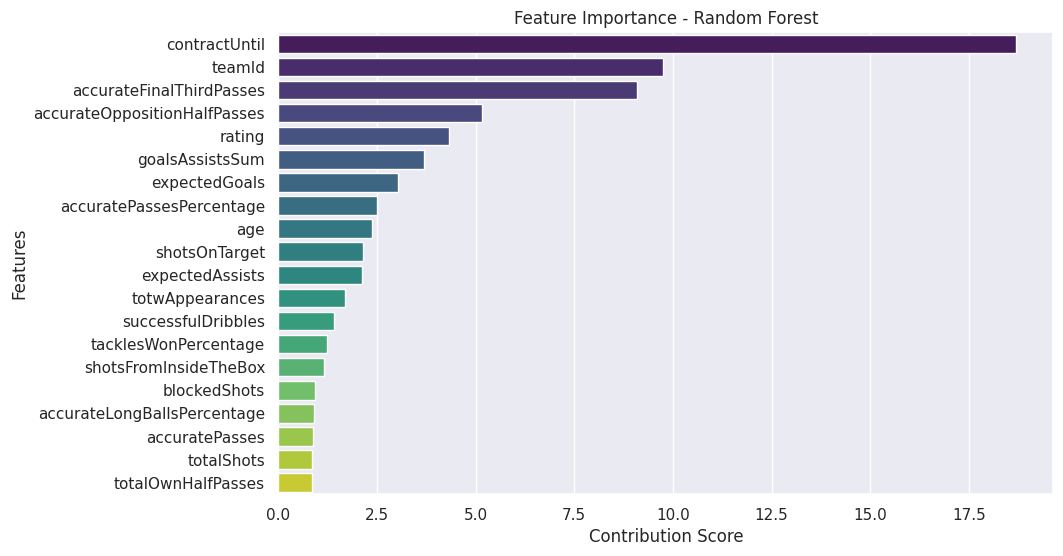

In [82]:
import pandas as pd

importances = rf_2.feature_importances_ * 100
feature_names = X_2.columns

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance (highest to lowest)
feature_df = feature_df.sort_values(by='Importance', ascending=False)[:20]

# print(feature_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')

plt.title('Feature Importance - Random Forest')
plt.xlabel('Contribution Score')
plt.ylabel('Features')
plt.show()

In [83]:
feature_df['Feature'][:20].to_list()

['contractUntil',
 'teamId',
 'accurateFinalThirdPasses',
 'accurateOppositionHalfPasses',
 'rating',
 'goalsAssistsSum',
 'expectedGoals',
 'accuratePassesPercentage',
 'age',
 'shotsOnTarget',
 'expectedAssists',
 'totwAppearances',
 'successfulDribbles',
 'tacklesWonPercentage',
 'shotsFromInsideTheBox',
 'blockedShots',
 'accurateLongBallsPercentage',
 'accuratePasses',
 'totalShots',
 'totalOwnHalfPasses']

Text(0.5, 1.0, 'Cumulative Feature Importance')

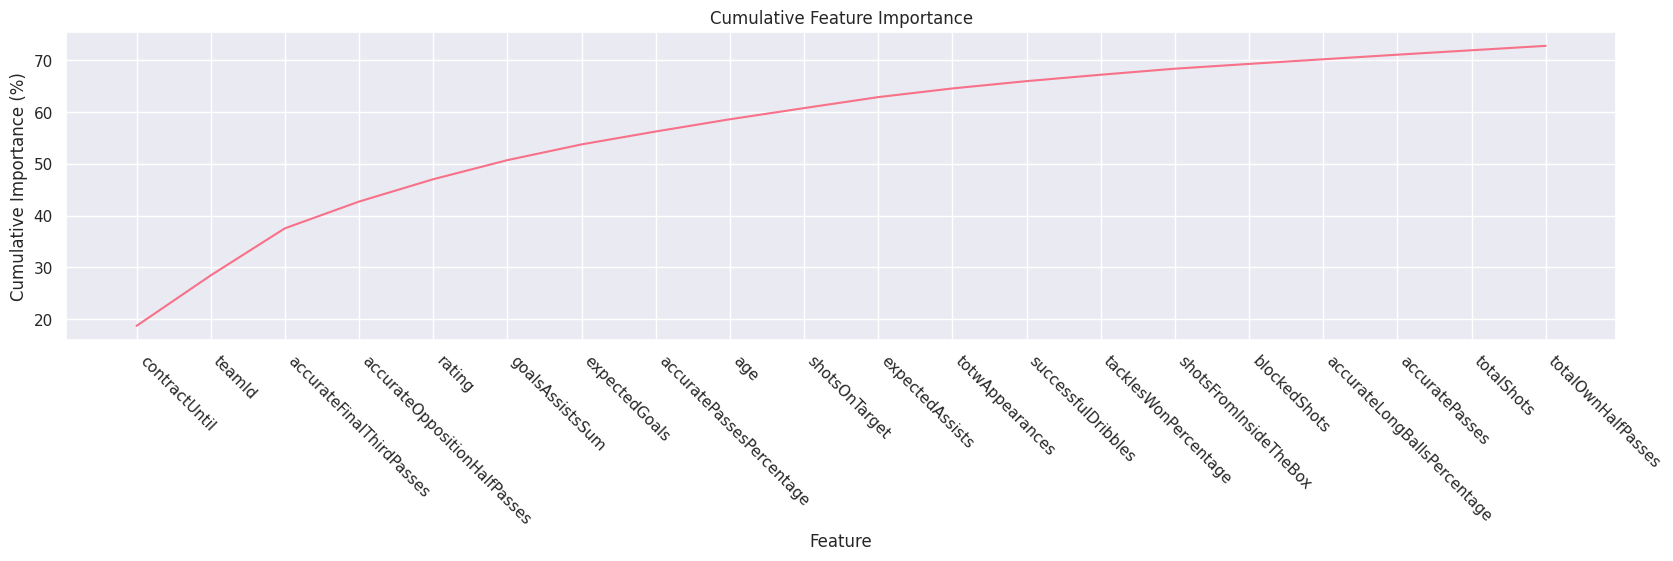

In [84]:
plt.figure(figsize=(20, 4))
temp = feature_df.cumsum()
temp["Feature"] = feature_df["Feature"]
sns.lineplot(temp, x="Feature", y="Importance")
plt.xticks(rotation=-45, ha="left")
plt.ylabel("Cumulative Importance (%)")
plt.title("Cumulative Feature Importance")

<Axes: >

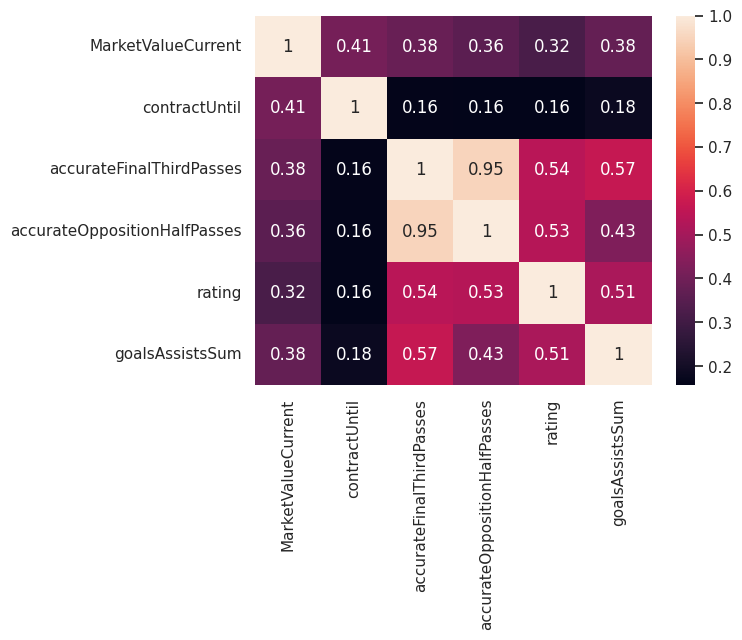

In [85]:
top_6_cols = feature_df['Feature'][:6].to_list()
top_6_cols.remove("teamId")
corr = df[['MarketValueCurrent'] + top_6_cols].corr()
# plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True)

In [86]:
feature_df.cumsum().head(6)

Feature  Importance
0                                       contractUntil   18.707041
1                                 contractUntilteamId   28.465605
24        contractUntilteamIdaccurateFinalThirdPasses   37.561205
23  contractUntilteamIdaccurateFinalThirdPassesacc...   42.730573
9   contractUntilteamIdaccurateFinalThirdPassesacc...   47.047489
17  contractUntilteamIdaccurateFinalThirdPassesacc...   50.738204

The first 6 features alone are responsible for over 50% of importance.

### Lasso

In [87]:
from scipy.stats import uniform

lasso_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=145446.38))
])

# param_distributions = {"model__alpha": uniform(100000, 1000000)}

# random_search_lasso = RandomizedSearchCV(
#     estimator=lasso_pipeline,
#     param_distributions=param_distributions,
#     n_iter=500,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search_lasso.fit(X_train_2, y_train_2)
lasso_pipeline.fit(X_train_2, y_train_2)
y_pred_3 = lasso_pipeline.predict(X_test_2)

In [88]:
# random_search_lasso.best_params_

In [89]:
loss = mean_squared_error(y_test_2, y_pred_3)
print(f"Root mean Squared Error: {loss}")

Root mean Squared Error: 100584869860444.14


In [90]:
lasso_coef = lasso_pipeline.named_steps['model'].coef_
lasso_coef = lasso_coef / np.abs(lasso_coef).sum() * 100

lasso_feature_df = pd.DataFrame({
    "Feature": X_train_2.columns,
    "Value": lasso_coef
}).sort_values(by="Value", ascending=False)

lasso_feature_df = pd.concat([lasso_feature_df[:10], lasso_feature_df[-5:]])
lasso_feature_df.head(10)

Feature      Value
114                 expectedGoals  11.565778
23   accurateOppositionHalfPasses  10.852685
0                   contractUntil   9.657882
113               totwAppearances   6.386587
26             successfulDribbles   4.778381
13              bigChancesCreated   3.442010
63                errorLeadToShot   2.971427
80                     cleanSheet   2.658383
3                          height   2.568300
24       accurateFinalThirdPasses   2.385582

<Axes: xlabel='Value', ylabel='Feature'>

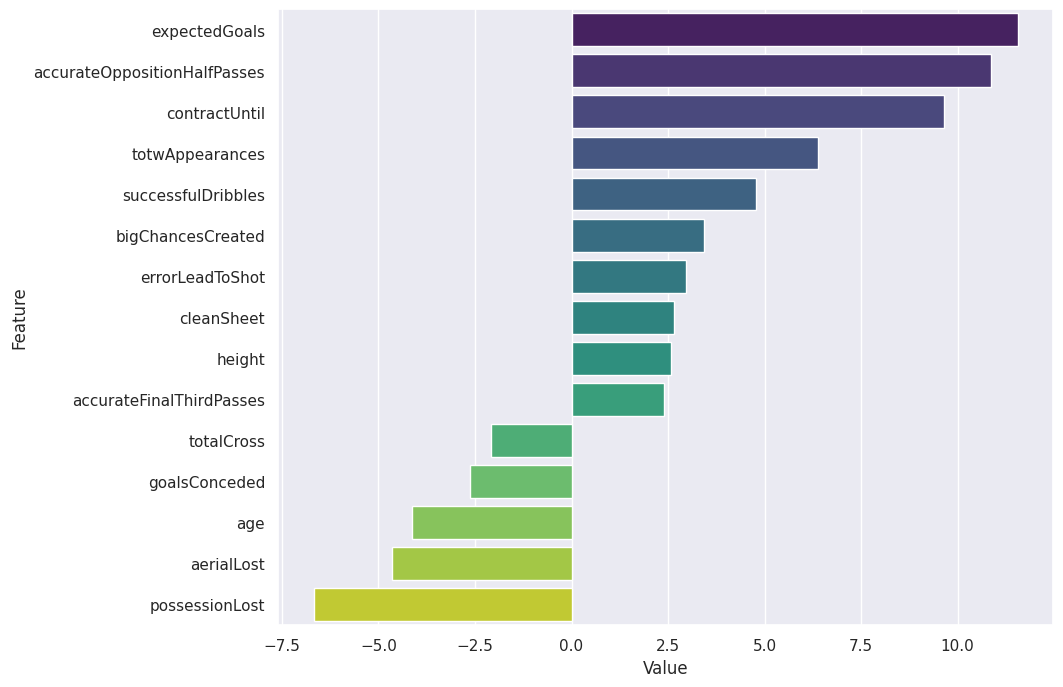

In [91]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Value', y='Feature', hue='Feature', data=lasso_feature_df, palette='viridis')

Compared to RF, LASSO excludes some id fields and only focus on values. Common fields between the 2 models are:
- contractUntil
- accurateFinalThirdPasses
- accurateOppositionHalfPasses
- expectedGoals
- accuratePassesPercentage
- age

In [92]:
# plt.figure(figsize=(15, 10))
# columns_for_plot = list(feature_df['Feature'])[:6] + ['MarketValueCurrent', 'position']
# sns.pairplot(df[columns_for_plot], hue='position', corner=True)
# plt.legend()

# EDA

## Analyse by remained time in contract

<Axes: xlabel='contractUntil', ylabel='MarketValueCurrent'>

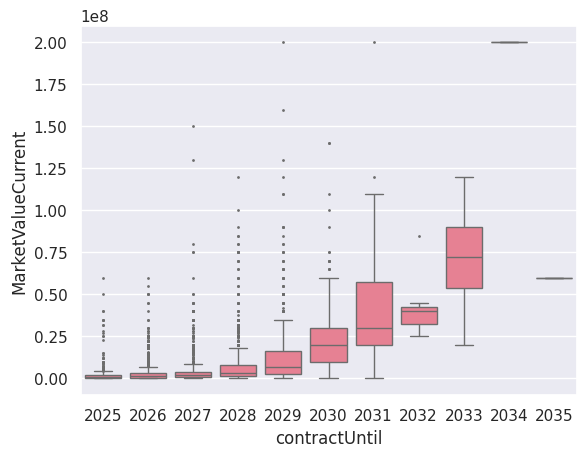

In [93]:
contract_df = df[["contractUntil", "MarketValueCurrent"]]
sns.boxplot(contract_df, x="contractUntil", y="MarketValueCurrent", fliersize=1)

Clearly that the remained time in contract of the player highly affect the transfer value, because the longer the remained time, the higher the compensation must be paid for the selling club.

## Analyse by passes

In [94]:
pass_df = df[["position", "accurateFinalThirdPasses", "accurateOppositionHalfPasses", "accuratePassesPercentage", "expectedGoals", "MarketValueCurrent"]]

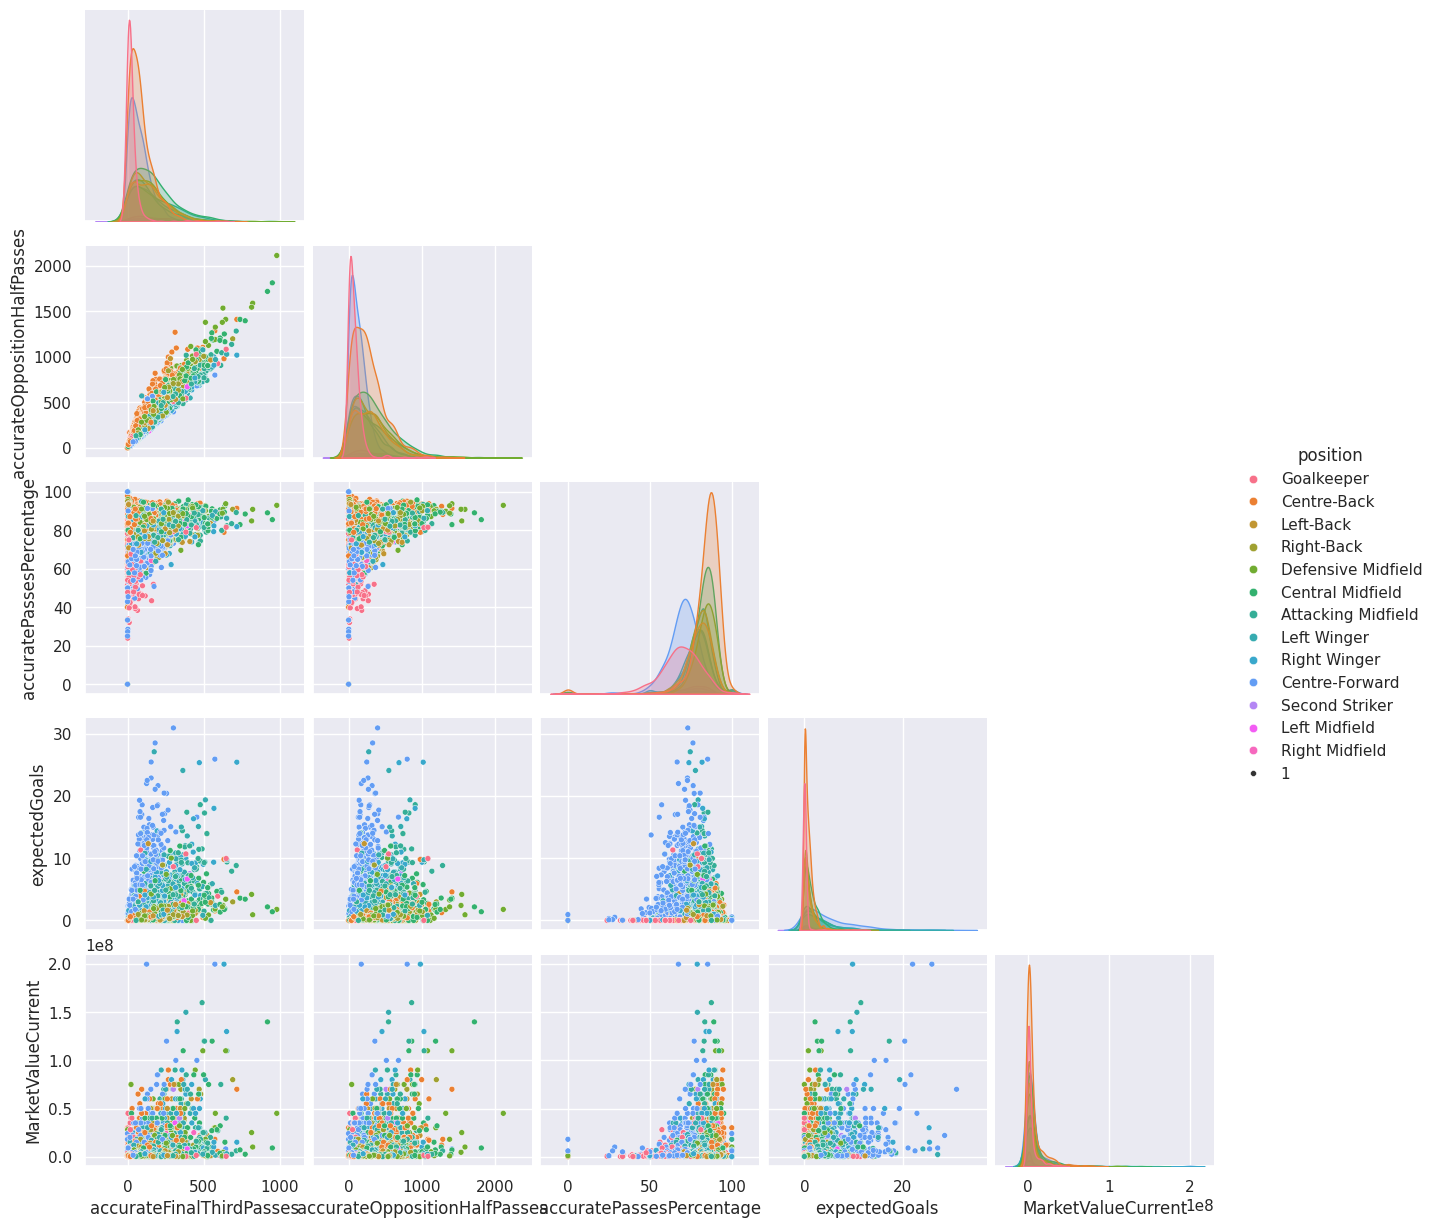

In [95]:
sns.pairplot(pass_df, hue="position", corner=True, plot_kws={"size":1})

AccurateOppositionHalfPasses highly correlates with accurateFinalThirdPasses

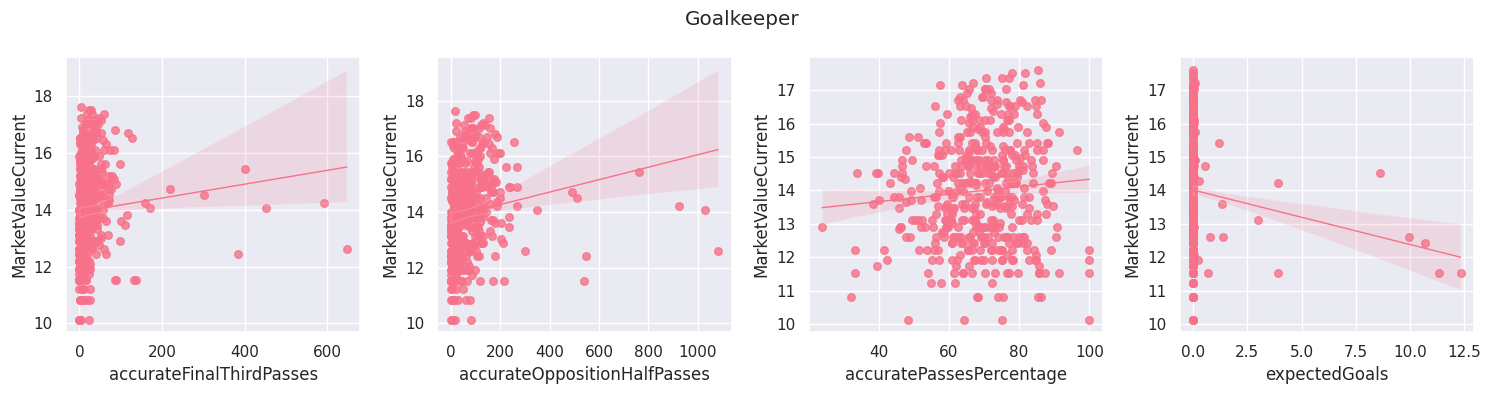

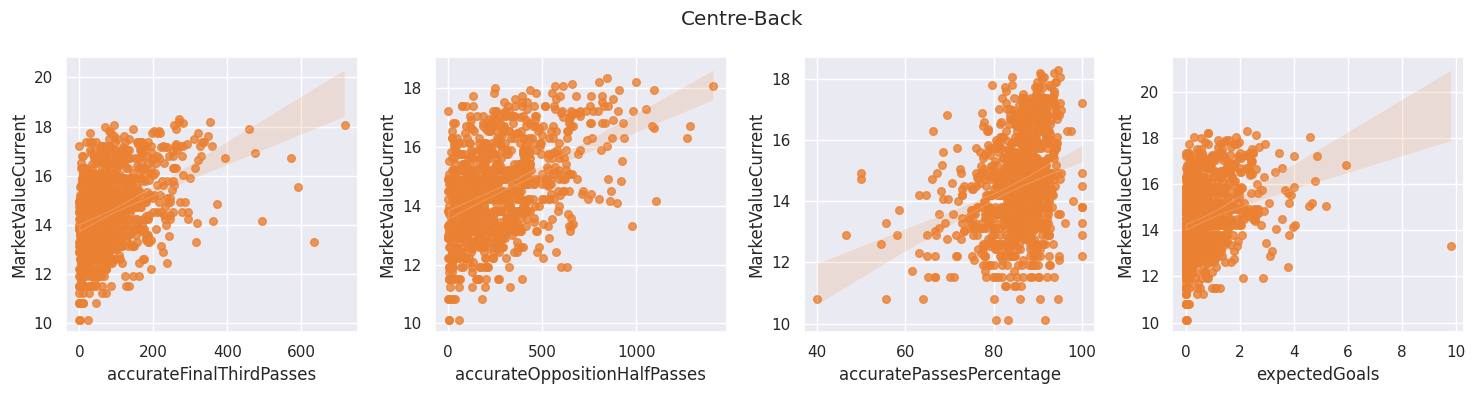

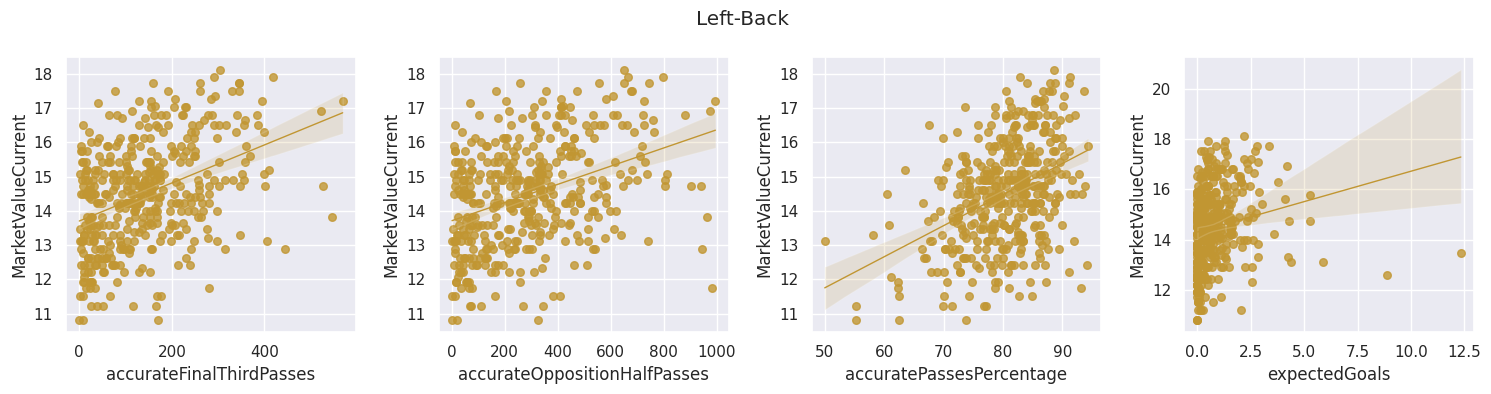

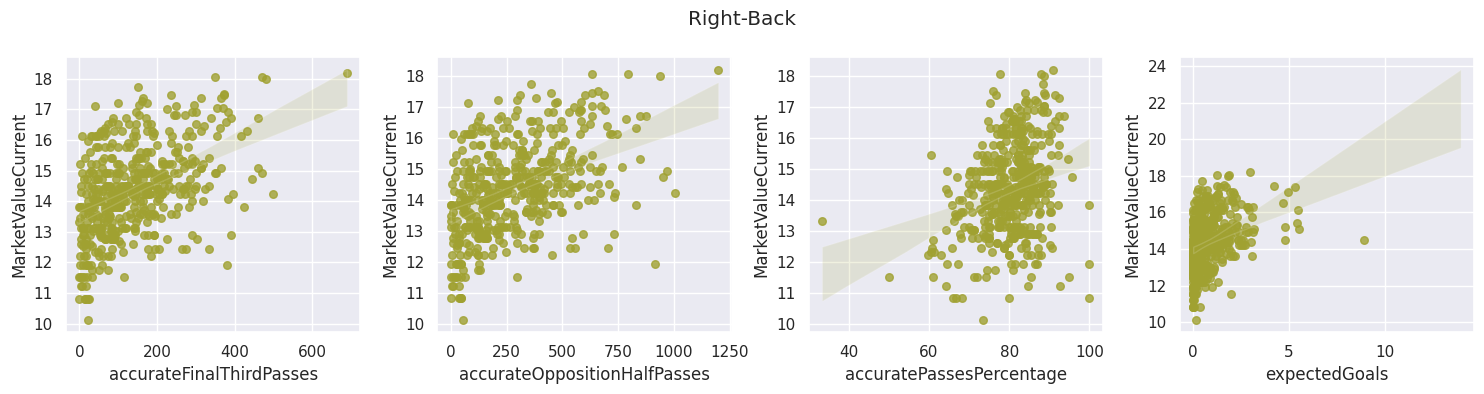

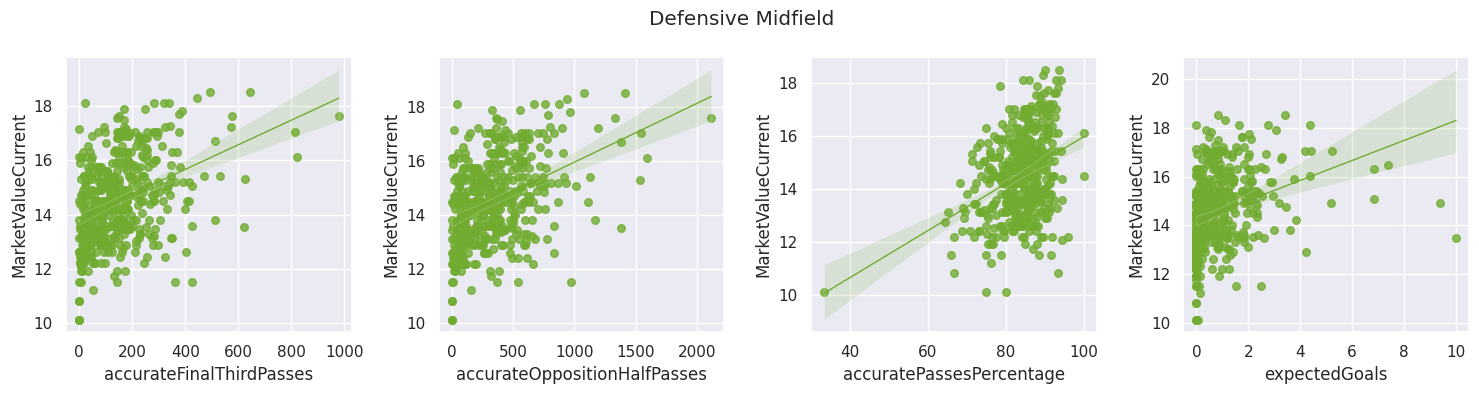

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


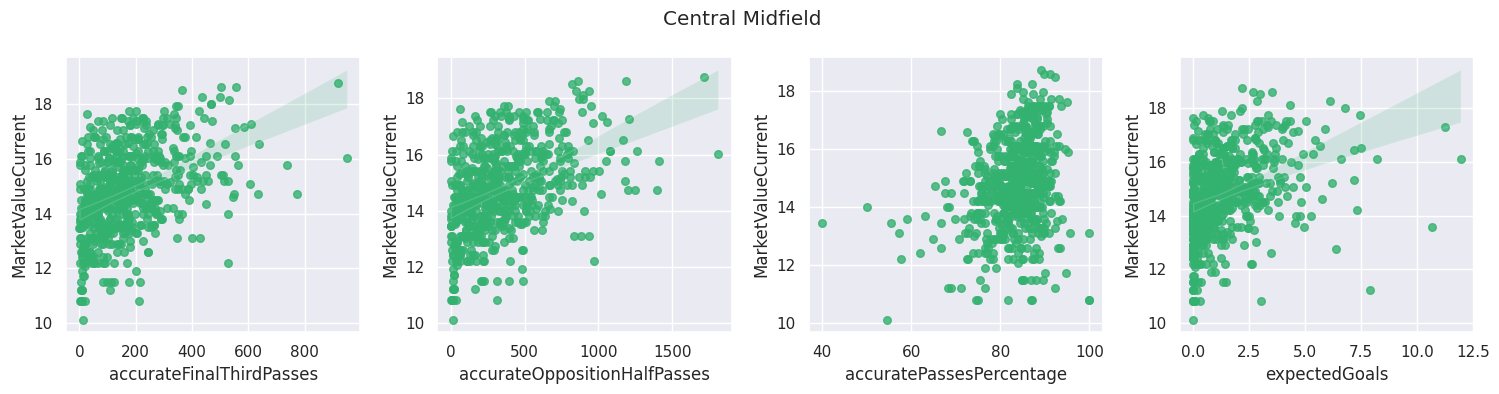

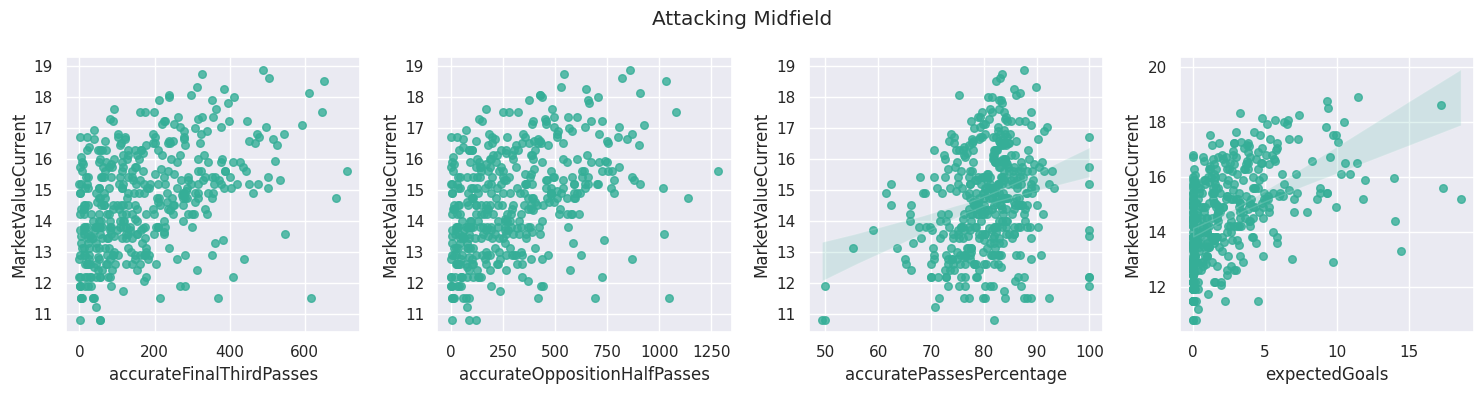

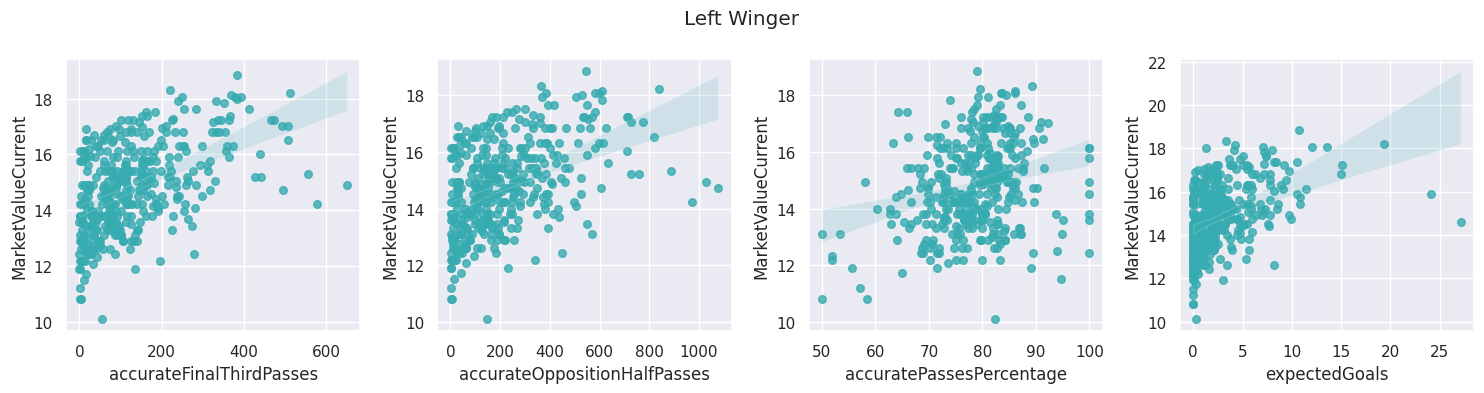

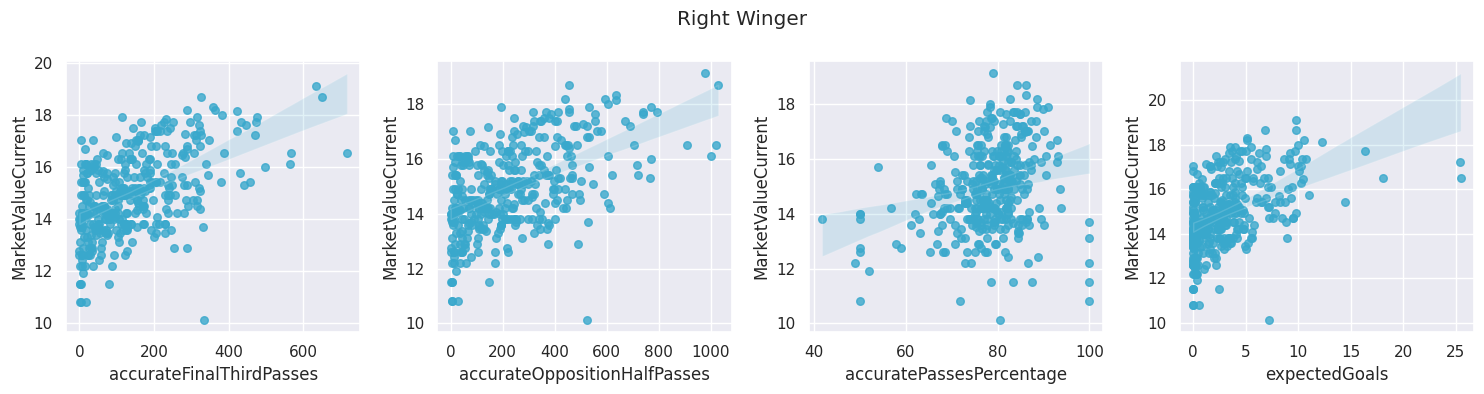

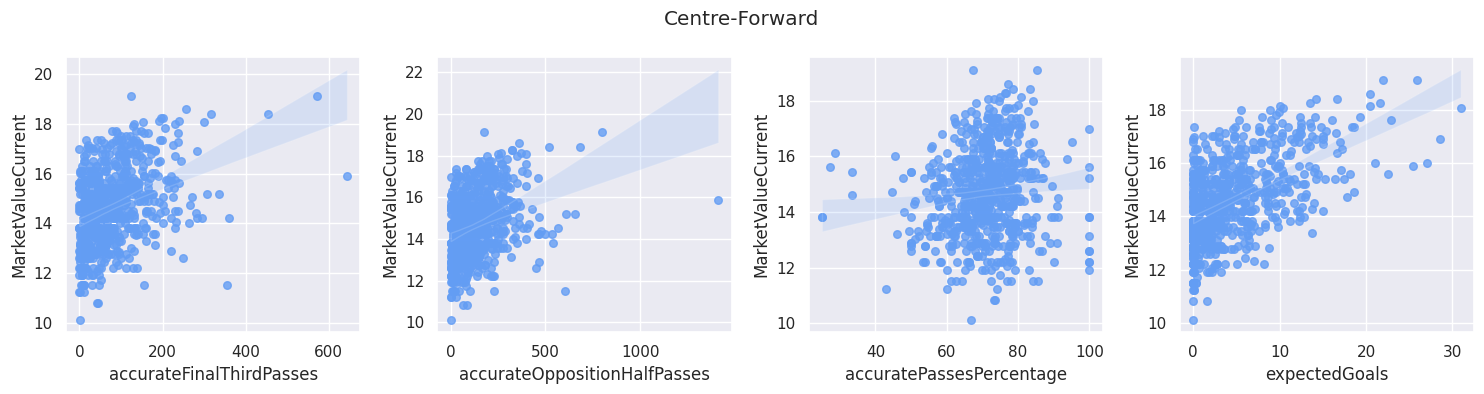

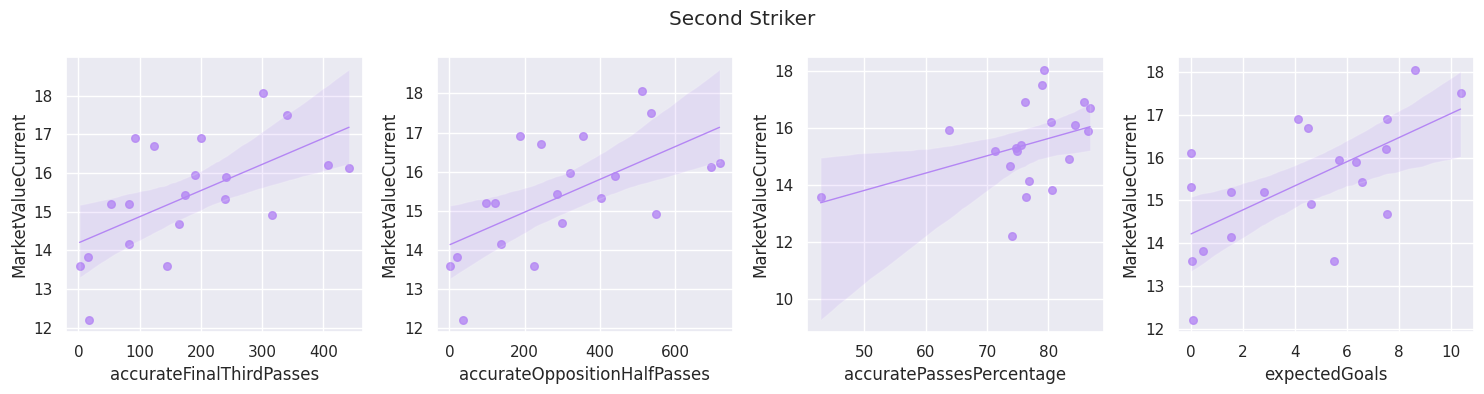

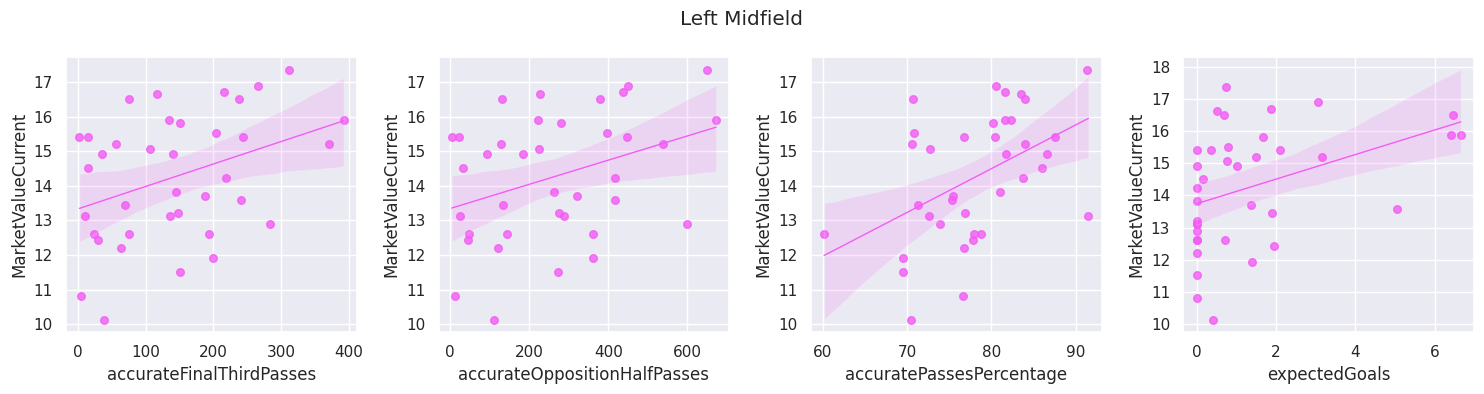

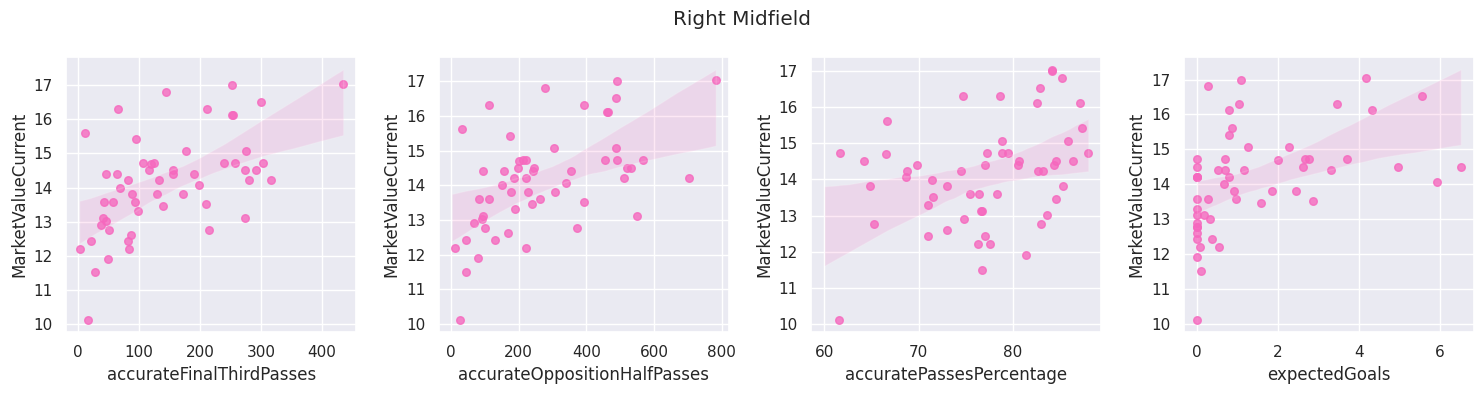

In [96]:
colors = sns.color_palette("husl", n_colors=13)
for _, pos in enumerate(pass_df["position"].unique()):
    temp = pass_df.copy()
    temp = temp[temp["position"] == pos]
    temp["MarketValueCurrent"] = temp["MarketValueCurrent"].apply(np.log)
    temp = temp[temp["accuratePassesPercentage"] != 0]
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(pass_df.columns[1:-1]):
        plt.subplot(1, len(pass_df.columns[1:-1]), i+1)
        sns.regplot(temp, x=col, y="MarketValueCurrent", scatter_kws={"s":30}, line_kws={"lw":1}, color=colors[_])
        plt.suptitle(pos)
    plt.tight_layout()
    plt.show()

- Most of the time, the market values correlate with **passes** and **expected goals** (except for goalkeeper, goalkeeper with high "expected goals" should be banned).
- The **accurate passes percentages** are mostly ~ $60-80 \%$, and don't seem to guarantee a higher value, even for $100%$ accuracy. Only the exceptional low accurate passes percentages $<60%$ guarantee lower values.
- **Backs** positions and **Attacking Midfield** values don't rely much on **accurateFinalThirdPasses** and **accurateOppositionHalfPasses**. For the case of **AM**, maybe the players are expected to pierce through and goal instantly whenever oppotunities come, so excellent passing ability is not a required criteria(?). Other positions (except goalkeeper)' value increase with the final third and opposition half pass' accuracy.
- **Attacking** positions' values heavily depend on the expected goals, and the correlation increases by position as **Midfields** $\to$ **Wings, CF**. On the other hand, expected goals are not required for **defensive/backs** positions.

In [97]:
pass_df

position  accurateFinalThirdPasses  \
0             Goalkeeper                      48.0   
1             Goalkeeper                       1.0   
2             Goalkeeper                       3.0   
3            Centre-Back                     268.0   
4            Centre-Back                     273.0   
...                  ...                       ...   
5461  Defensive Midfield                     363.0   
5462    Central Midfield                      83.0   
5463  Attacking Midfield                      56.0   
5464        Right Winger                     114.0   
5465      Centre-Forward                      37.0   

      accurateOppositionHalfPasses  accuratePassesPercentage  expectedGoals  \
0                            132.0                 66.949953         0.0741   
1                             16.0                 91.469194         0.0000   
2                             16.0                 87.468031         0.0000   
3                            998.0                 93.631802         0.8260   
4                            651.0                 92.385392         2.3181   
...                            ...                       ...            ...   
5461                         539.0                 88.609272         2.4741   
5462                         147.0                 75.570033         4.8356   
5463                         134.0                 87.601078         0.0000   
5464                         199.0                 76.675603         4.0833   
5465                          67.0                 70.000000         3.4270   

      MarketValueCurrent  
0             30000000.0  
1              7000000.0  
2               900000.0  
3             80000000.0  
4             30000000.0  
...                  ...  
5461            100000.0  
5462           2000000.0  
5463            200000.0  
5464           3000000.0  
5465           1500000.0  

[5466 rows x 6 columns]

## Analyse by positions

In [98]:
plt.figure(figsize=(20, 4))
position_sum_df = pd.concat([df[["position", "playerId"]].groupby("position").count().rename({"playerId":"n_transfers"}, axis=1),
                            df[["position", "MarketValueCurrent"]].groupby("position").mean()], axis=1) \
                            .sort_values(by="n_transfers", ascending=False)
position_sum_df.head()

n_transfers  MarketValueCurrent
position                                         
Centre-Back              1010        6.457748e+06
Centre-Forward            692        7.784501e+06
Central Midfield          635        7.943189e+06
Right-Back                470        4.955106e+06
Goalkeeper                470        3.823191e+06

<Figure size 2000x400 with 0 Axes>

<Axes: xlabel='position', ylabel='n_transfers'>

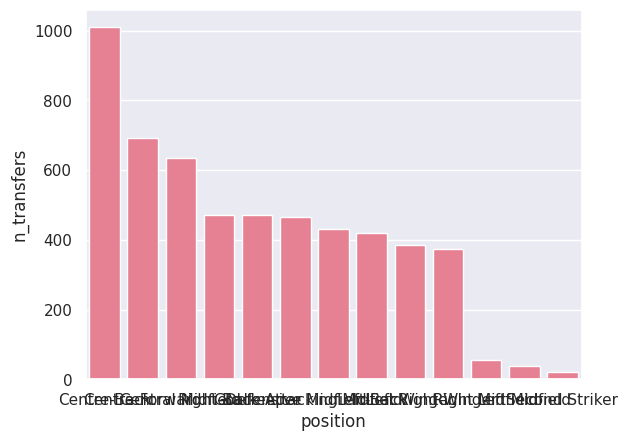

In [99]:
position_sum_df_plot = position_sum_df.reset_index()   # index -> column

sns.barplot(data=position_sum_df_plot, x="position", y="n_transfers")


ValueError: List of boxplot statistics and `positions` values must have same the length

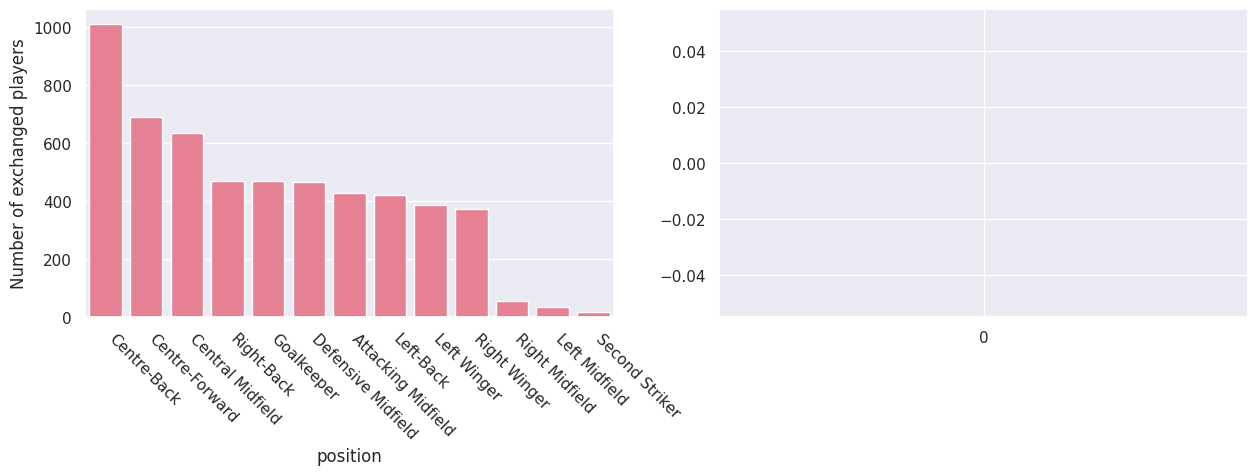

In [100]:
position_sum_df = position_sum_df.reset_index()   # index -> column
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.barplot(data=position_sum_df, x="position", y="n_transfers")
plt.xticks(rotation=-45, ha="left")
plt.ylabel("Number of exchanged players")

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x="position", y="MarketValueCurrent", order=position_sum_df.index, showfliers=False)
plt.xticks(rotation=-45, ha="left")

plt.suptitle("Number and Value of transfered football players by Position")

Text(0.5, 1.0, 'Value of transfered football players by Position')

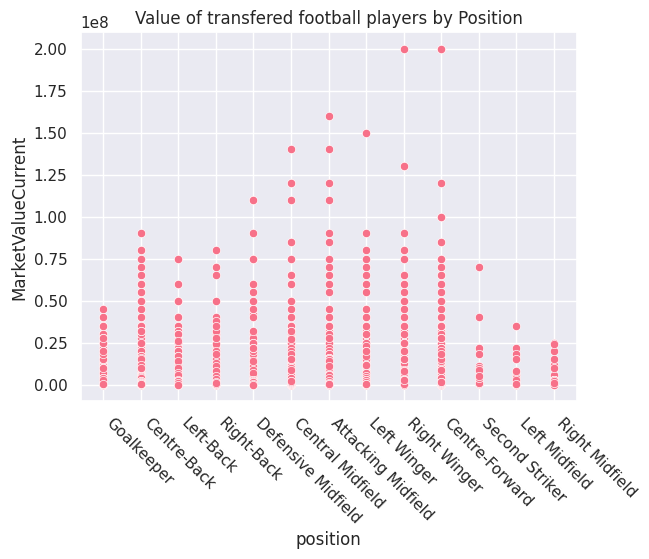

In [101]:
temp = df[["position", "MarketValueCurrent"]]
# temp["MarketValueCurrent"] = temp["MarketValueCurrent"].apply(np.log)
sns.scatterplot(data=temp, x="position", y="MarketValueCurrent")
plt.xticks(rotation=-45, ha="left")
plt.title("Value of transfered football players by Position")

(I don't know much about football. Fix me if I made any mistake)

**Analysation**:

- **Centre-Back** is the position with the most transfers, followed by **Central-Forward** and **Central-Midfield**.
- **Right-Back, Left-Back, Goalkeeper** have similar number of transfers compared to **Defensive Midfield, Attacking Midfield, Left Wing** and **Right Wing**, but their values are much lower.
- **Right Midfield, Left Midfield** and **Second Striker** have little transfers.

**Explanation**:
The value by position, in general, increases with the chance of scoring.

As my understanding, top-tier modern football no longer use 4-4-2 formation, which means the traditional **RM, LM** positions are also washed out. Instead, they adopt 4-3-3 or 4-2-3-1 to enhance the dominance in the central, which explains why the transfers of **central** positions are the most common. Those modern formations switch the role of **Side Midfield** to **libero/DM** or **Wings**. For the case of **SS**, modern football prefers 1 fast **CF** and many flexible attaking-defending players rather than an additional pure offensive player. This is the main reason for the scarity of **RM, LM, SS** positions.

In general, attacking players got higher values. **SS** got exceptional high value because: (1) This position is rare, (2) **SS** is often employed by top-tier clubs to sometimes test double strikers formation, but most of the time they play versatilely as a wing (which also have high value). What suprises me the most is that **CF**, the position that was expected to be the chance-seeker and primary goalscorer, in general has lower value range than even central/atk midfields and wings, although some of them really got astronomical high value. Like, how? Football bros explain this for me, pls.

We dont think the differences is much noticeable because when we eliminate outliers, they all quite the same. But in case you still wonder, maybe there are more exceptional players in those positions than CF and the data dont show much to us.

**RB, LB, Goalkeeper** don't score, so paying too much for them don't polish the scoreboard much.

In [ ]:
# temp = df[["position", "MarketValueCurrent"]]
# temp["MarketValueCurrent"] = temp["MarketValueCurrent"].apply(np.log)

# plt.figure(figsize=(20, 12))
# for i, pos in enumerate(temp["position"].unique()):
#     plt.subplot(4, 4, i+1)
#     temp2 = temp[temp["position"] == pos]
#     sns.histplot(temp2, x="MarketValueCurrent")
#     plt.title(pos)
# plt.tight_layout()
# plt.show()

## Analyse by teams

In [ ]:
team_df = df[["teamName", "MarketValuePrevious"]]
team_df.head()

Data này là data về từng cầu thủ trong clb chứ không phải thông tin về các lần chuyển nhượng.

In [ ]:
team_df = pd.concat([team_df.groupby(by="teamName").count().rename({"MarketValuePrevious":"n_transfers"}, axis=1),
                     team_df.groupby(by="teamName").sum().rename({"MarketValuePrevious":"totalValue"}, axis=1)],
                     axis=1) \
                    .sort_values(by="totalValue", ascending=False)

team_df.head()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# n_transfers histplot
sns.histplot(team_df, x="n_transfers", ax=ax1, kde=True)
median_transfers = team_df["n_transfers"].median()
mean_transfers = team_df["n_transfers"].mean()
ax1.axvline(x=median_transfers, color="red", linestyle='--', label=f'Median: {median_transfers:.1f}')
ax1.axvline(x=mean_transfers, color="blue", linestyle='--', label=f'Mean: {mean_transfers:.1f}')
ax1.legend()
ax1.set_title("Number of transfers by teams")

# log totalValue histplot
log_totalValue = team_df[["totalValue"]].apply(np.log)
sns.histplot(log_totalValue, x="totalValue", ax=ax2, kde=True)

median_value = log_totalValue["totalValue"].median()
mean_value = log_totalValue["totalValue"].mean()
var_value = log_totalValue["totalValue"].var()

normal_range = np.arange(12, 22, 0.1)
normal_values = norm.pdf(normal_range, loc=mean_value, scale=np.sqrt(var_value))
normal_values = normal_values / float(normal_values.max()) * 40
sns.lineplot(x=normal_range, y=normal_values, ax=ax2, color="green", label=f"Normal dist(loc={mean_value:.1f}, scale={np.sqrt(var_value):.1f})")

ax2.axvline(x=median_value, color="red", linestyle='--', label=f'Median: {median_value:.1f}')
ax2.axvline(x=mean_value, color="blue", linestyle='--', label=f'Mean: {mean_value:.1f}')
ax2.legend()

ax2.set_title("Total transfer value by teams (Natural logarithm)")
fig.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(6, 4))
temp = team_df.reset_index()[["teamName", "n_transfers"]]
temp = pd.merge(df[["teamName", "MarketValuePrevious"]], temp, on="teamName", how="left")
temp["MarketValuePrevious"] = temp["MarketValuePrevious"].apply(np.log)
n_bins = 3 # Increase this if you want less box.
max_transfers = temp["n_transfers"].max()
temp["bin"] = (temp["n_transfers"] - 1) // n_bins
bin_range = range((max_transfers - 1) // n_bins + 1)

sns.boxplot(temp, x="bin", y="MarketValuePrevious")
plt.xticks(ticks=bin_range, labels=[f"[{n_bins * i + 1}-{min(max_transfers, n_bins * (i + 1))}]" for i in bin_range])

plt.xlabel("Number of transfers range")
plt.title("Transfer value by teams boxplot (Natural logarithm)")
plt.show()

In [ ]:
temp = (team_df['totalValue'] / team_df['totalValue'].sum() * 100).cumsum()
n_temp = int(0.2 * len(temp))
temp.iloc[n_temp]


this is not quite right 

- 50% of the teams has made more than or equals to 20 transfers.
- Teams made more transfers tend to pay higher compared to teams rarely made any transfer.
- The log total transfer values by team ~ normal distribution. \
$\Rightarrow$ The total transfer values by team ~ Pareto distribution (the famous 80/20 principle). \
$\Rightarrow$ Reality: 20% of the clubs paid 74% of total transfer value. \
$\Rightarrow$ The transfer values DID heavily depend on the budget of the club. The player in club with higher budget also get higher value too. A promising topic for this phenomenon is to find undervalued players, whose have the adequate skill for a specialist but valued lower because they are not playing for big names.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['MarketValueCurrent'], bins=30)
plt.xlabel("MarketValueCurrent")
plt.ylabel("Frequency")
plt.title("Distribution of MarketValueCurrent")
plt.show()



In [ ]:
plt.figure()
plt.hist(df['MarketValueCurrent'], bins=30)
plt.yscale("log")   # hoặc dùng xscale nếu lệch theo trục x
plt.xlabel("MarketValueCurrent")
plt.ylabel("Frequency (log)")
plt.title("Distribution of MarketValueCurrent (log scale)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))

plt.hist(
    df['MarketValueCurrent'],
    bins=20,
    color="steelblue",
    
    alpha=0.8
)

plt.yscale("log")

plt.xlabel("MarketValueCurrent", fontsize=11)
plt.ylabel("Frequency (log scale)", fontsize=11)
plt.title("Distribution of MarketValueCurrent (Log Scale)", fontsize=13, pad=10)

plt.grid(
    True,
    which="both",
    linestyle="--",
    linewidth=0.5,
    alpha=0.6
)

# format trục y cho dễ đọc
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.tight_layout()
plt.show()


Phân phối gần giống log-normal

Tức là:

log(MarketValueCurrent) ≈ phân phối gần chuẩn

Có đuôi dài (heavy tail)

Giá trị lớn tồn tại nhưng rất hiếm

Tần suất giảm đều khi giá trị tăng

Không phải noise → có cấu trúc

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))

plt.hist(
    df['MarketValueCurrent'],
    bins=20,
    color="steelblue",
    alpha=0.8
)


plt.xlabel("MarketValueCurrent", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.title("Distribution of MarketValueCurrent", fontsize=13, pad=10)

plt.grid(
    True,
    which="major",         
    linestyle="--",
    linewidth=0.5,
    alpha=0.6
)

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

df = df.copy()
df['y_log'] = np.log1p(df['MarketValueCurrent'])
X = df.drop(columns=['MarketValueCurrent', 'y_log'])
y = df['y_log']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ("scaler", StandardScaler()),   
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipeline.fit(X_train, y_train)
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

print("RMSE (original scale):", rmse)
print("MAE  (original scale):", mae)
rmse_log = mean_squared_error(y_test, y_pred_log, squared=False)
print("RMSE (log scale):", rmse_log)
y_new_log = pipeline.predict(X_new)
y_new = np.expm1(y_new_log)



In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


In [ ]:
import xgboost as xgb

booster = xgb_model.get_booster()
score = booster.get_score(importance_type="gain")

# map f0, f1 -> feature name
fmap = {f"f{i}": col for i, col in enumerate(X_train.columns)}

feature_df_gain = pd.DataFrame({
    "Feature": [fmap.get(k, k) for k in score.keys()],
    "Importance": list(score.values())
}).sort_values("Importance", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_df_gain,
    x="Importance",
    y="Feature"
)

plt.title("Feature Importance - XGBoost (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="rmse",      # loss
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True             # in loss mỗi iteration
)


In [ ]:
evals = xgb_model.evals_result()

train_rmse = evals["validation_0"]["rmse"][-1]
test_rmse  = evals["validation_1"]["rmse"][-1]

print(f"Final Train RMSE: {train_rmse:,.4f}")
print(f"Final Test  RMSE: {test_rmse:,.4f}")


In [ ]:
import matplotlib.pyplot as plt

evals = xgb_model.evals_result()
train_curve = evals["validation_0"]["rmse"]
test_curve  = evals["validation_1"]["rmse"]

plt.figure(figsize=(10, 5))
plt.plot(train_curve, label="Train RMSE")
plt.plot(test_curve, label="Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("XGBoost RMSE per Iteration")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import xgboost as xgb

booster = xgb_model.get_booster()
score = booster.get_score(importance_type="gain")

# map f0, f1 -> feature name
fmap = {f"f{i}": col for i, col in enumerate(X_train_2.columns)}

feature_df_gain = pd.DataFrame({
    "Feature": [fmap.get(k, k) for k in score.keys()],
    "Importance": list(score.values())
}).sort_values("Importance", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_df_gain,
    x="Importance",
    y="Feature"
)

plt.title("Feature Importance - XGBoost (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
print(f"Train RMSE: {train_mse**0.5:,.2f}")
print(f"Test  RMSE: {test_mse**0.5:,.2f}")



/tmp/ipykernel_55/1611446961.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


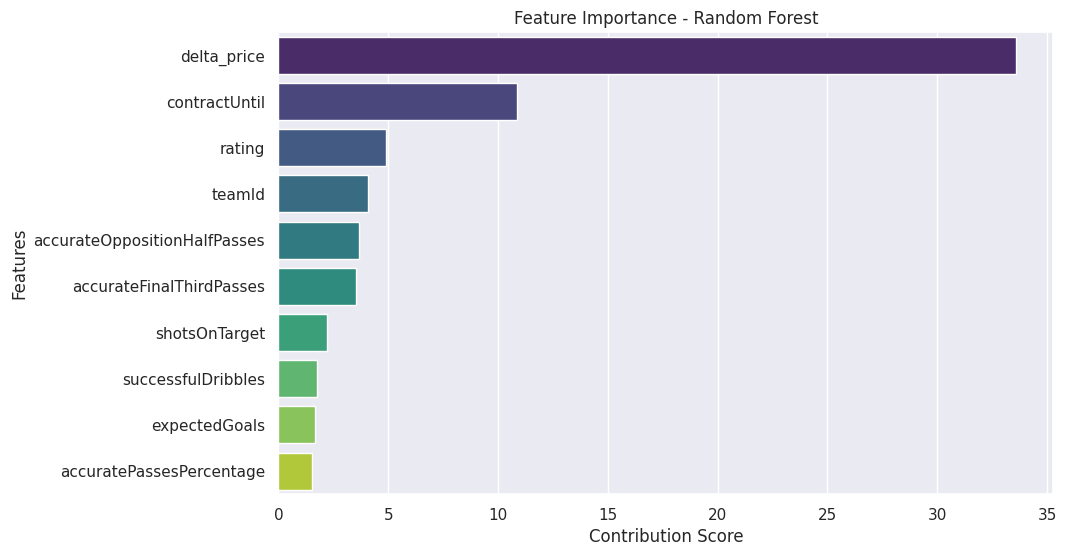

In [102]:
df["delta_price"] = (
    df["MarketValueCurrent"] - df["MarketValuePrevious"]
).fillna(0)

# X = df.drop(['MarketValueCurrent', 'MarketValuePrevious'], axis=1)
drop_cols = ['player_name', 'preferredFoot',
                'position', 'firstSidePosition', 'secondSidePosition', 'teamName', 'name',
                'date_of_birth', 'MarketValueCurrent', 'playerId', 'id', "MarketValuePrevious"]
X = df.drop(drop_cols, axis=1).select_dtypes("number")
y = df['MarketValueCurrent']

cols = X.columns

X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf = RandomForestRegressor(
    n_estimators=136,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

# grid_random = {
#     'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf_random = RandomizedSearchCV(
#     estimator = rf,
#     param_distributions = grid_random,
#     n_iter = 20, # Number of parameter settings to sample
#     cv = 3,
#     verbose = 2,
#     random_state = 42,
#     n_jobs = -1
# )

rf.fit(X_train, y_train)
# rf_random.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# y_pred = rf_random.predict(X_test)
# best_params = rf_random.best_params_
# {'n_estimators': 136, 'min_samples_split': 10, 'min_samples_leaf': 1}

importances = rf.feature_importances_ * 100 # percentage
feature_names = X.columns

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sort highest -> lowest
feature_df = feature_df.sort_values(by='Importance', ascending=False)[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')

plt.title('Feature Importance - Random Forest')
plt.xlabel('Contribution Score')
plt.ylabel('Features')
plt.show()

Text(0.5, 1.0, 'Changes in price of transfered football players by Position')

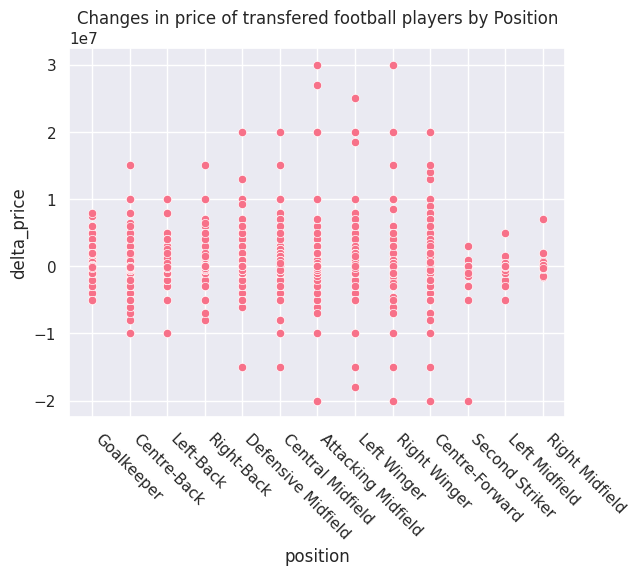

In [104]:
temp = df[["position", "delta_price"]]
# temp["MarketValueCurrent"] = temp["MarketValueCurrent"].apply(np.log)
sns.scatterplot(data=temp, x="position", y="delta_price")
plt.xticks(rotation=-45, ha="left")
plt.title("Changes in price of transfered football players by Position")

In [105]:
pass_df = df[["position", "accurateFinalThirdPasses", "accurateOppositionHalfPasses", "accuratePassesPercentage", "expectedGoals", "delta_price"]]

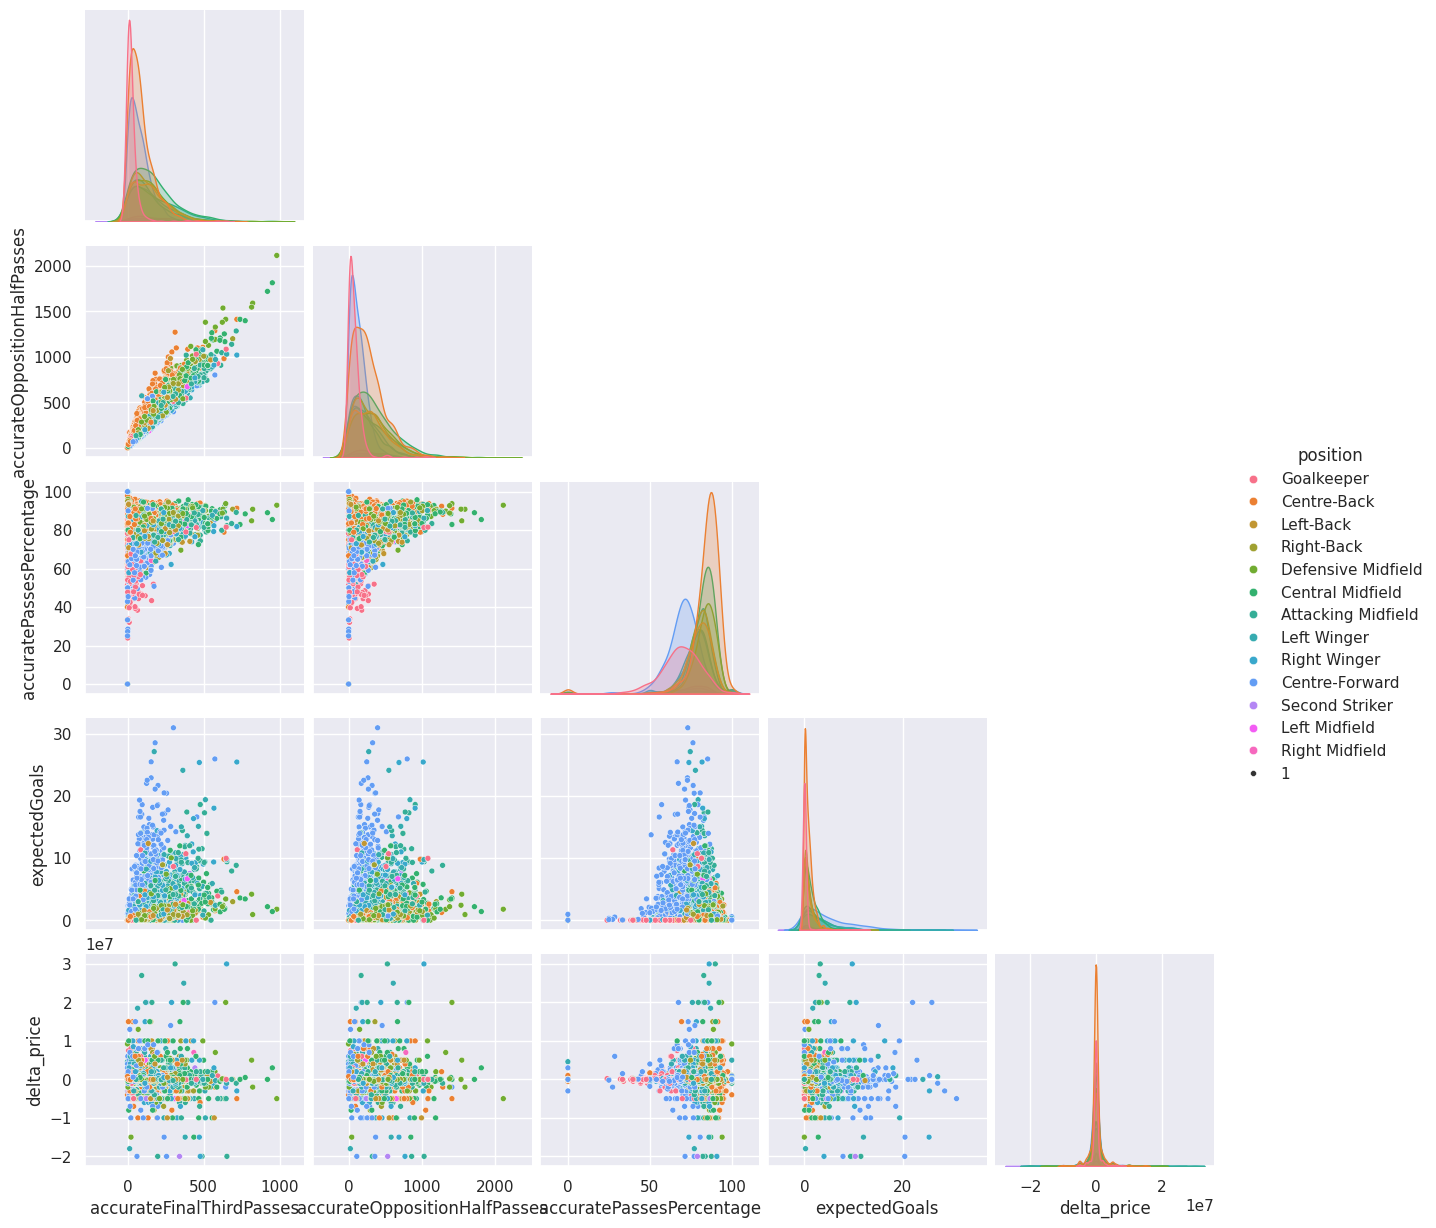

In [106]:
sns.pairplot(pass_df, hue="position", corner=True, plot_kws={"size":1})

/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


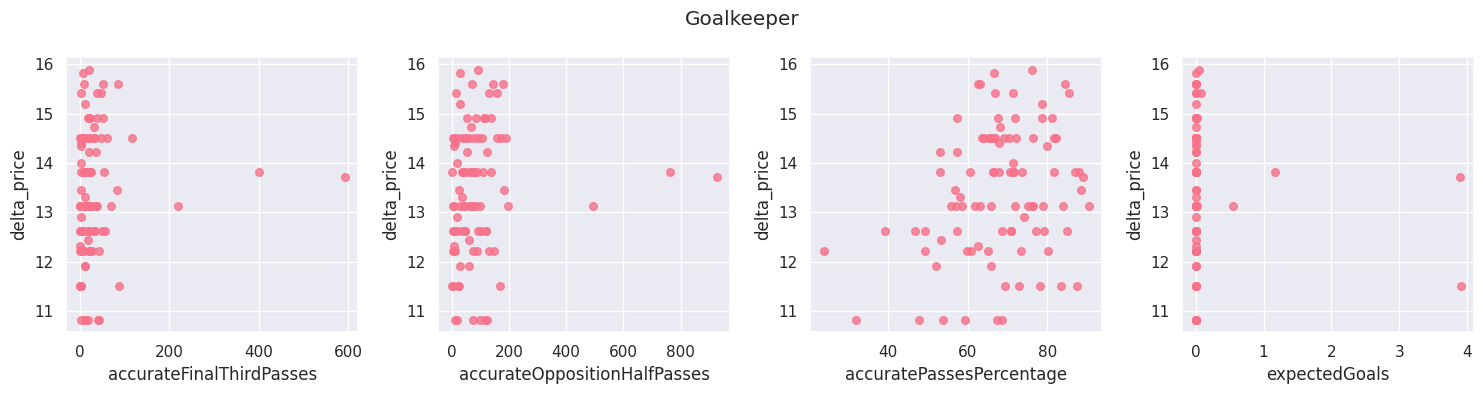

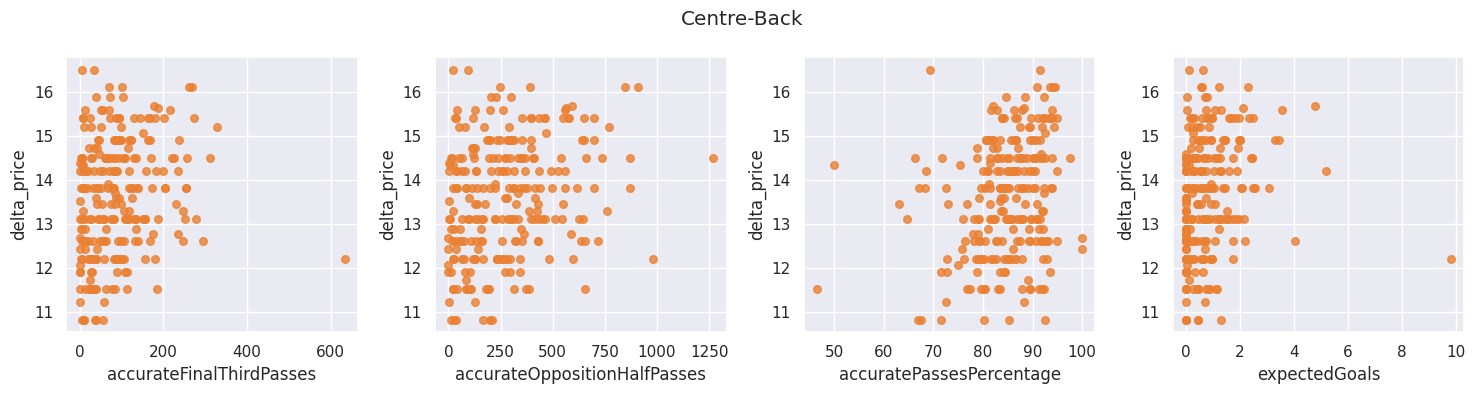

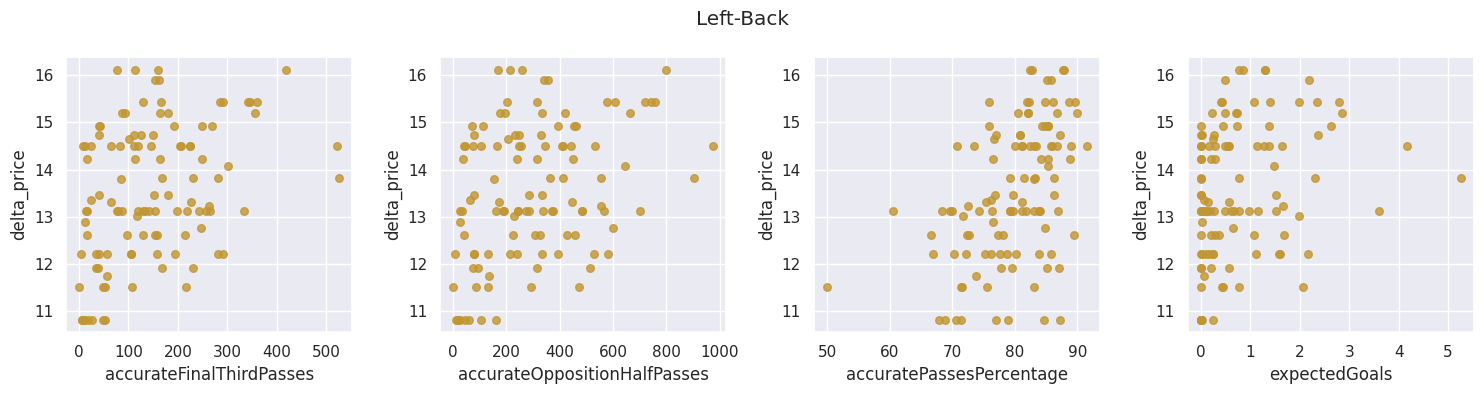

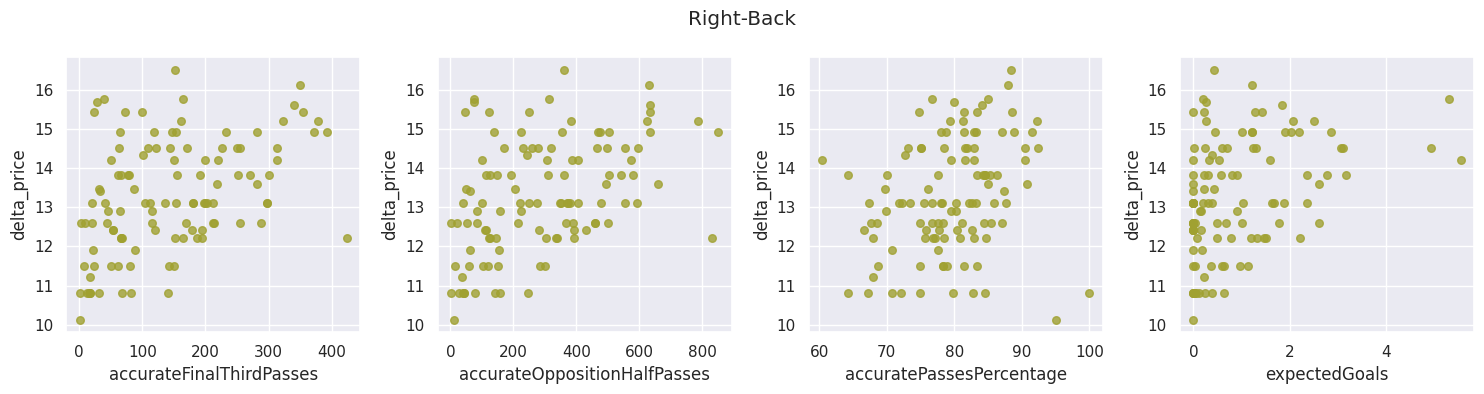

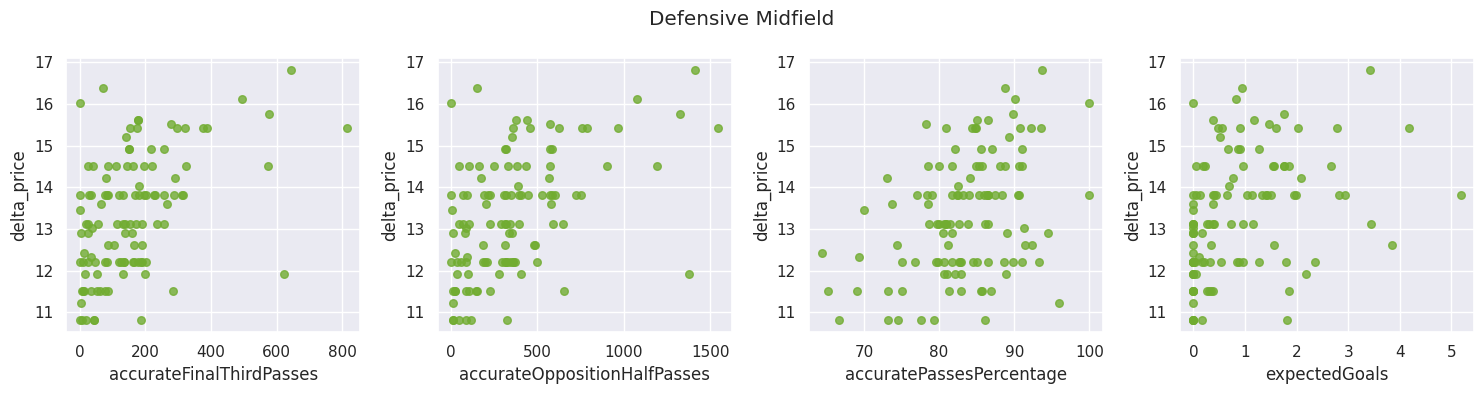

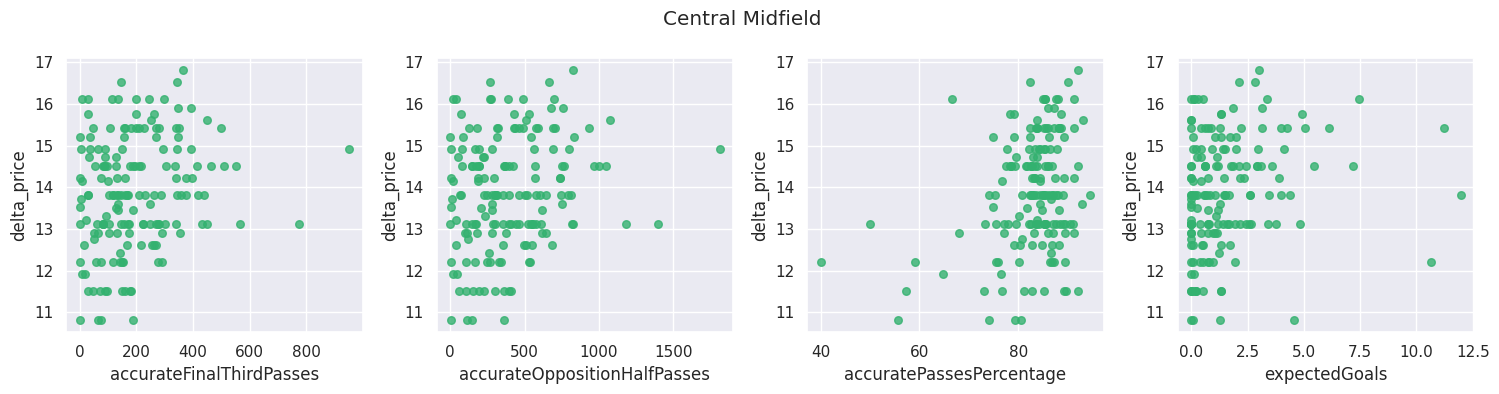

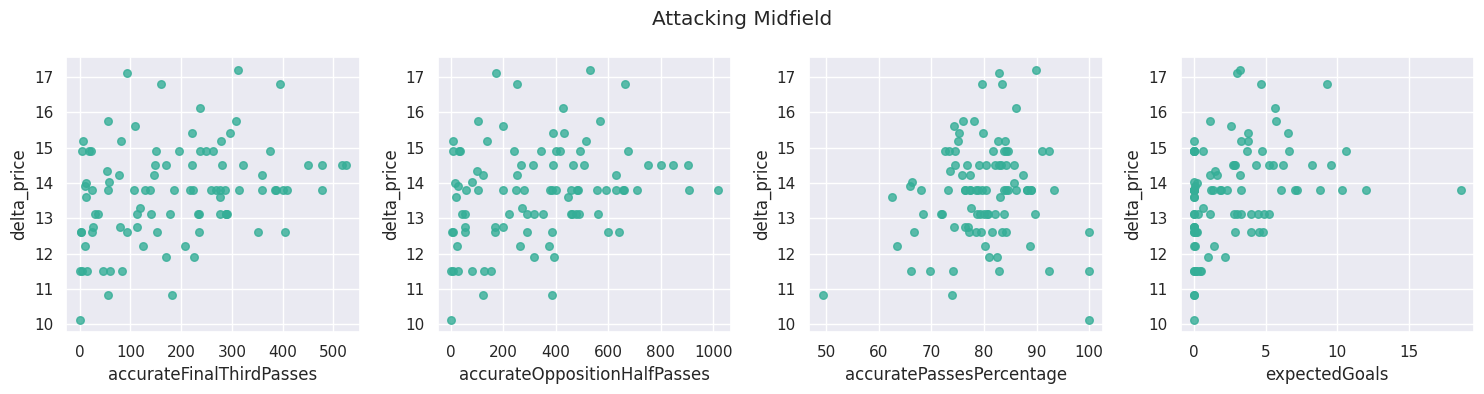

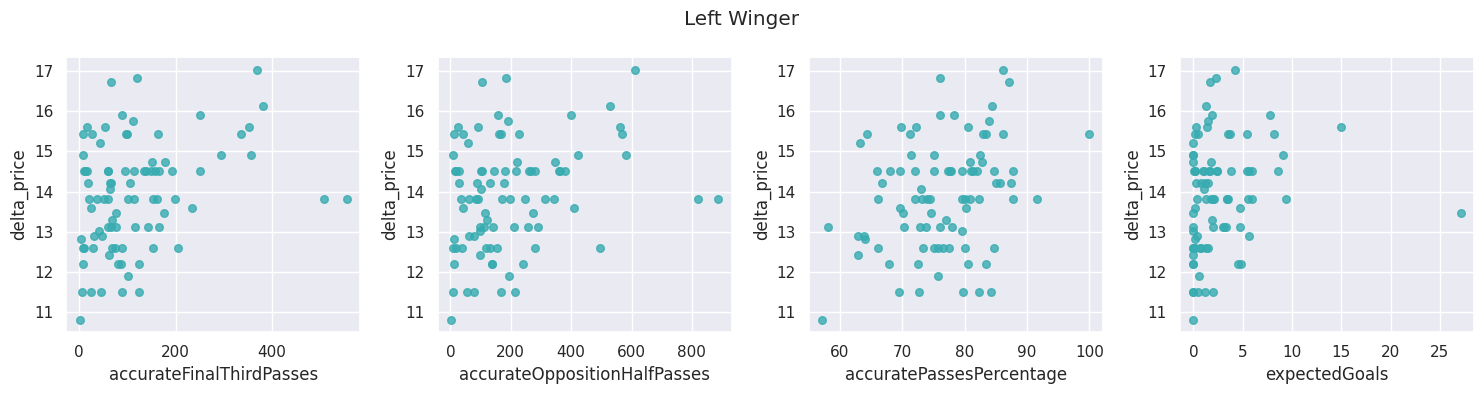

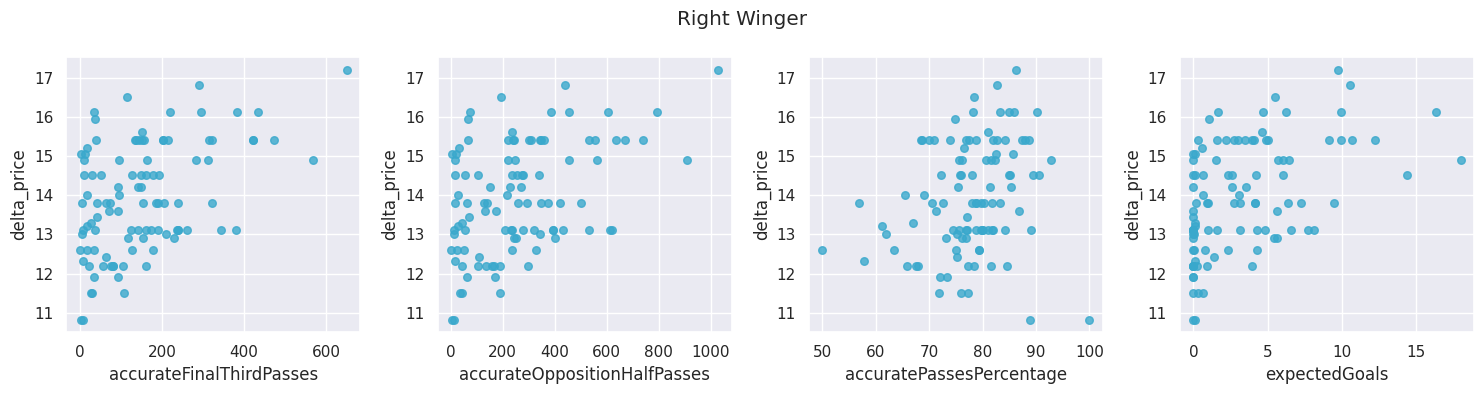

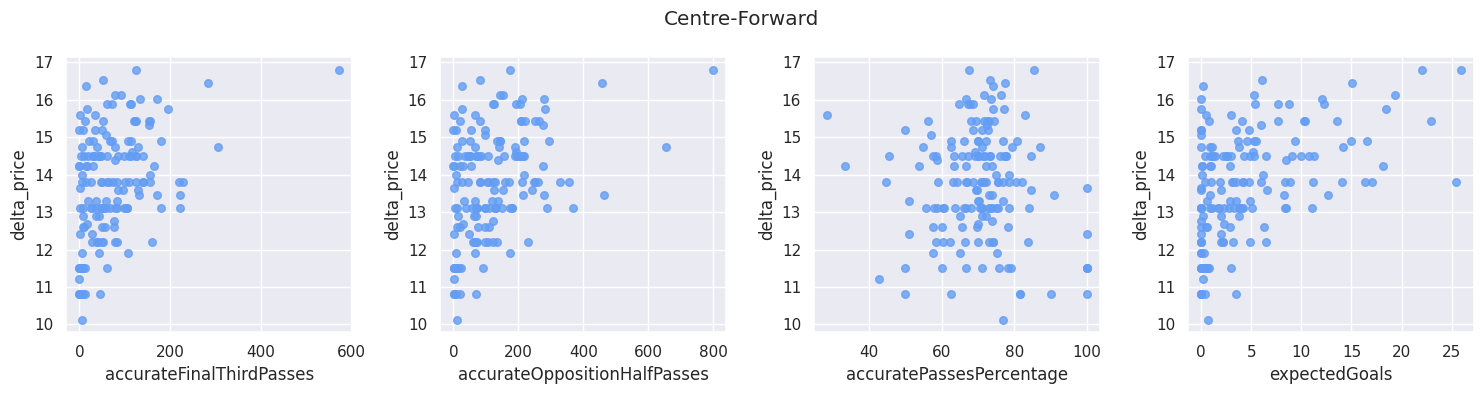

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4781: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


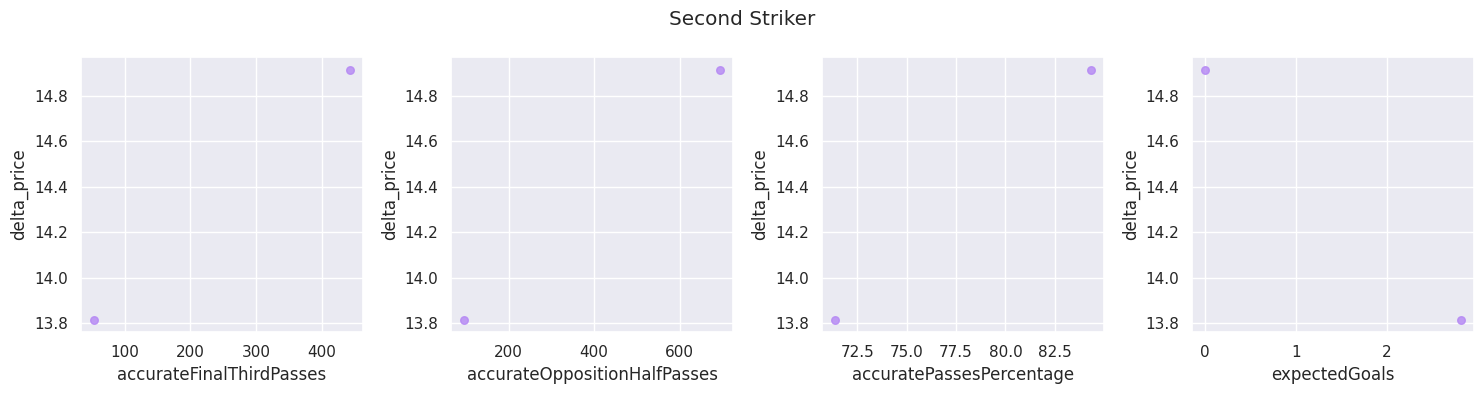

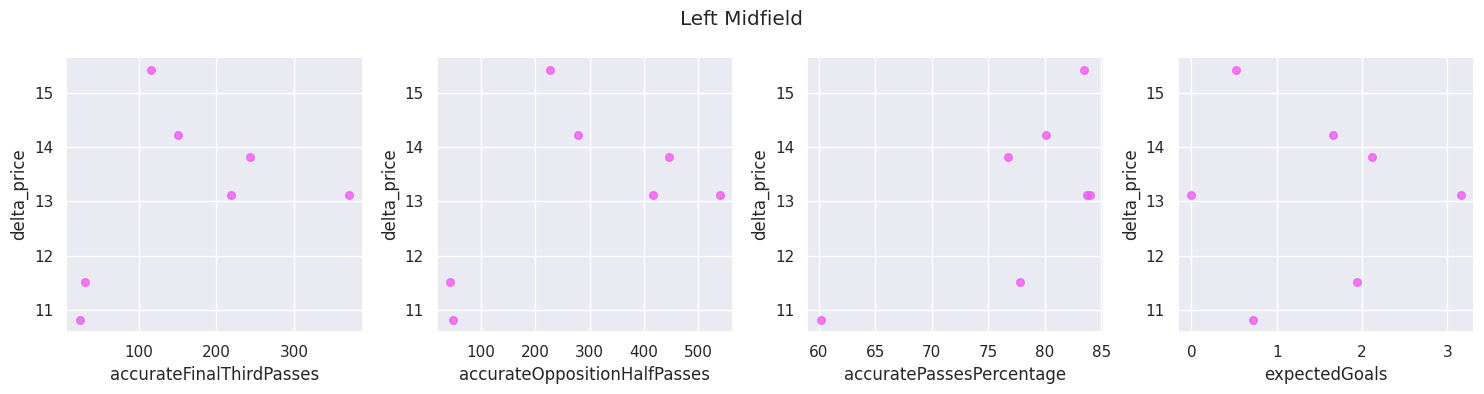

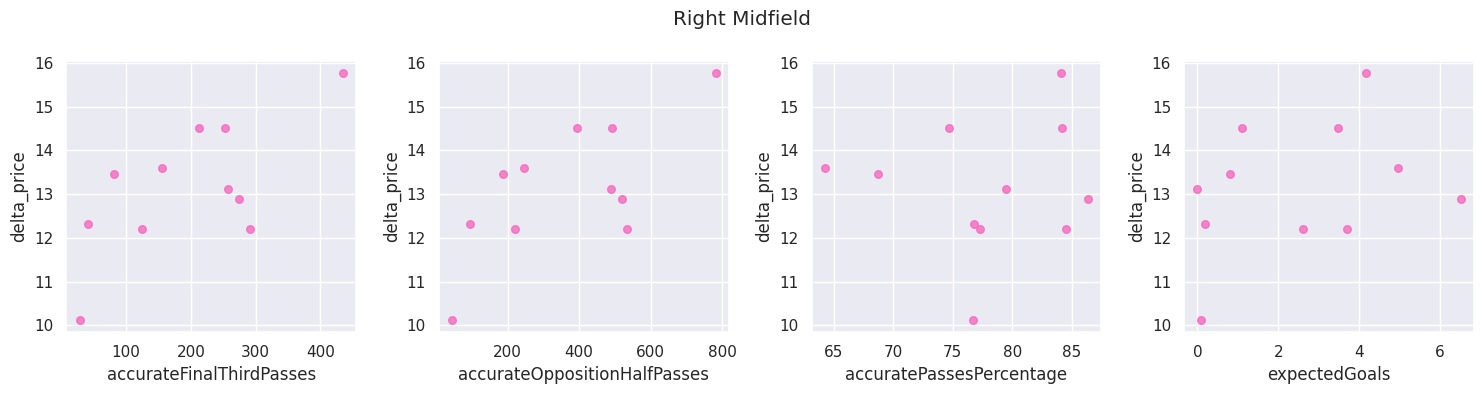

In [107]:
colors = sns.color_palette("husl", n_colors=13)
for _, pos in enumerate(pass_df["position"].unique()):
    temp = pass_df.copy()
    temp = temp[temp["position"] == pos]
    temp["delta_price"] = temp["delta_price"].apply(np.log)
    temp = temp[temp["accuratePassesPercentage"] != 0]
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(pass_df.columns[1:-1]):
        plt.subplot(1, len(pass_df.columns[1:-1]), i+1)
        sns.regplot(temp, x=col, y="delta_price", scatter_kws={"s":30}, line_kws={"lw":1}, color=colors[_])
        plt.suptitle(pos)
    plt.tight_layout()
    plt.show()

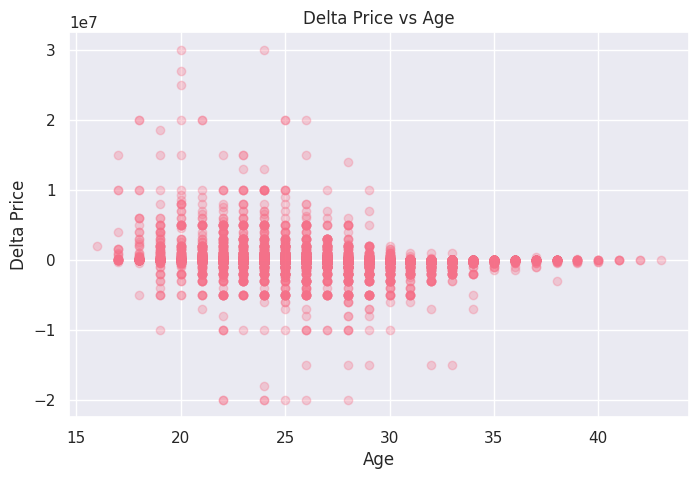

Correlation (delta_price vs age): -0.16475038626289928


In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df["age"], df["delta_price"], alpha=0.3)
plt.xlabel("Age")
plt.ylabel("Delta Price")
plt.title("Delta Price vs Age")
plt.show()
corr_age = df["age"].corr(df["delta_price"])
print("Correlation (delta_price vs age):", corr_age)


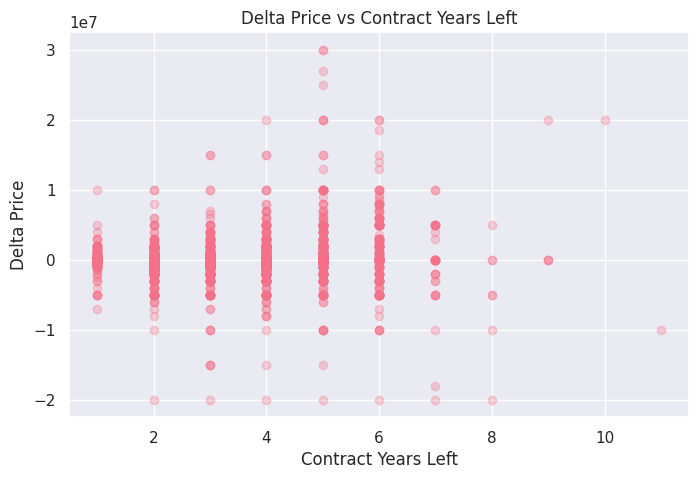

Correlation (delta_price vs contract years left): 0.10535336762903189


In [111]:
current_year = 2024  # hoặc df["contractUntil"].max() - 1

df["contract_years_left"] = df["contractUntil"] - current_year
plt.figure(figsize=(8, 5))
plt.scatter(df["contract_years_left"], df["delta_price"], alpha=0.3)
plt.xlabel("Contract Years Left")
plt.ylabel("Delta Price")
plt.title("Delta Price vs Contract Years Left")
plt.show()
corr_contract = df["contract_years_left"].corr(df["delta_price"])
print("Correlation (delta_price vs contract years left):", corr_contract)


In [112]:
features = [
    "age",
    "minutesPlayed",
    "rating",
    "totalRating",
    "goals",
    "assists",
    "expectedGoals",
    "expectedAssists",
    "goalsAssistsSum",
    "MarketValueCurrent",
    "MarketValuePrevious",
    "delta_price",
    "contract_years_left"
]
features = [f for f in features if f in df.columns]


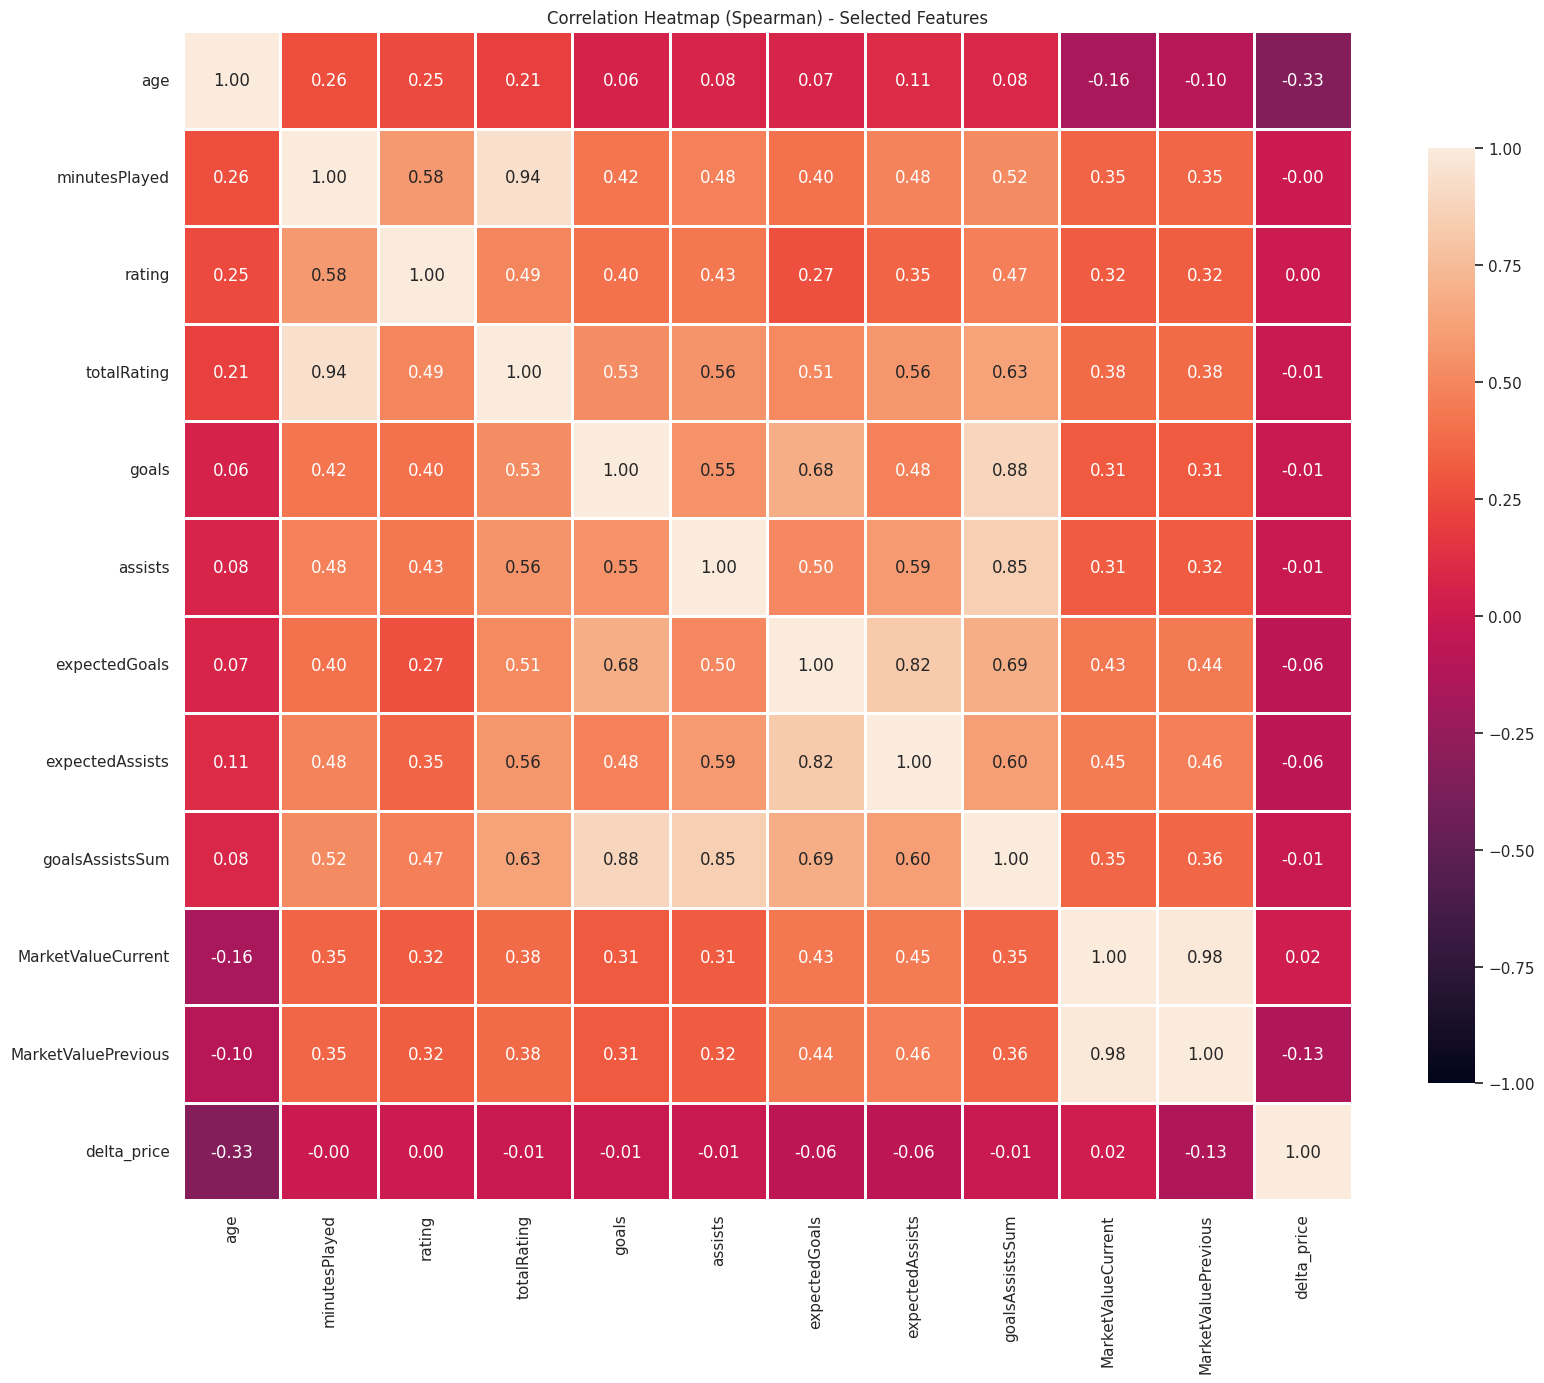

In [121]:
# =========================
# 2) Choose columns (giữ "các cột kia")
# =========================
features = [
    "age",
    "minutesPlayed",
    "rating",
    "totalRating",
    "goals",
    "assists",
    "expectedGoals",
    "expectedAssists",
    "goalsAssistsSum",
    "MarketValueCurrent",
    "MarketValuePrevious",
    "delta_price",
    "contract_years_left",
    # "delta_price_log",  # bật nếu muốn dùng log thay delta_price
]
features = [c for c in features if c in df.columns]

num_df = df[features].apply(pd.to_numeric, errors="coerce")
num_df = num_df.loc[:, num_df.std(numeric_only=True) > 0]  # drop constant cols

# =========================
# 3) Correlation + seaborn heatmap with annotations
# =========================
METHOD = "spearman"  # hoặc "pearson"
corr = num_df.corr(method=METHOD)

plt.figure(figsize=(1.2*len(corr.columns) + 3, 1.0*len(corr.columns) + 2))
ax = sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    linewidths=1, linecolor="white",
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title(f"Correlation Heatmap ({METHOD.capitalize()}) - Selected Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()






